In [ ]:
!pip install qiskit[visualisation]
!pip install qiskit-aer
!pip install qiskit-ibm-runtime
!pip install qiskit-machine-learning
!pip install pylatexenc

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 121.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 127.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.2/366.2 kB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 12.4 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not curren

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Create a folder in your Drive to store metrics
log_dir = '/content/drive/MyDrive/Colab Notebooks/DELE CA2 C/log'
import os
os.makedirs(log_dir, exist_ok=True)
print("Logging to:", log_dir)

Mounted at /content/drive
Logging to: /content/drive/MyDrive/Colab Notebooks/DELE CA2 C/log


In [ ]:
# Colab Cell 0: Install Qiskit-Aer, Mount Drive, and Resilient Aer Imports

import os
log_dir = '/content/drive/MyDrive/ca2_metrics_logs'
os.makedirs(log_dir, exist_ok=True)
print("Logging to:", log_dir)

# 3) Resilient Aer imports
from qiskit import QuantumCircuit
try:
    from qiskit.providers.aer import AerSimulator
    from qiskit.providers.aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, ReadoutError
    has_circ_save = hasattr(QuantumCircuit, "save_density_matrix")
except ImportError:
    from qiskit_aer import AerSimulator
    from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, ReadoutError
    has_circ_save = False

if not has_circ_save:
    try:
        from qiskit.providers.aer.library import SaveDensityMatrix
    except ImportError:
        from qiskit_aer.library import SaveDensityMatrix

# Cell 1: Imports & Settings

import time
import numpy as np
import scipy.linalg
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

from qiskit import transpile
from qiskit.visualization import (
    plot_histogram,
    plot_state_city,
    plot_state_paulivec,
    plot_bloch_multivector
)

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Experiment settings
qubit_list           = [3, 5, 7]
n_fid                = 500
batch_size           = 64
epochs               = 150
latent_dim_classical = 100

# Visualization font sizes
title_size = 10
tick_size  = 8
label_size = 9

Logging to: /content/drive/MyDrive/ca2_metrics_logs


In [ ]:
# Cell 2: Data Prep & Real FID Statistics

# 1) Prepare Binary MNIST
(x_train, y_train), _ = mnist.load_data()
mask = (y_train == 0) | (y_train == 1)
x = x_train[mask].astype('float32')
y = y_train[mask]
x = (x / 127.5) - 1.0
x = x.reshape((-1, 28*28))

idx0, idx1 = np.where(y==0)[0], np.where(y==1)[0]
m = min(len(idx0), len(idx1))
idx = np.concatenate([
    np.random.choice(idx0, m, replace=False),
    np.random.choice(idx1, m, replace=False)
])
np.random.shuffle(idx)
x_bin = x[idx]

dataset = (
    tf.data.Dataset.from_tensor_slices(x_bin)
      .shuffle(2048)
      .batch(batch_size)
      .prefetch(tf.data.AUTOTUNE)
)

# 2) Precompute real FID stats
inception = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

def preprocess_for_inception(imgs):
    imgs = (imgs.reshape(-1,28,28) + 1)*127.5
    imgs = np.stack([imgs,imgs,imgs], -1)
    return preprocess_input(tf.image.resize(imgs, [299,299]).numpy())

idx_fid       = np.random.choice(len(x_bin), n_fid, replace=False)
real_imgs_fid = x_bin[idx_fid]
real_acts     = inception.predict(preprocess_for_inception(real_imgs_fid), verbose=0)
mu1           = real_acts.mean(axis=0)
sigma1        = np.cov(real_acts, rowvar=False)

def calculate_fid(mu1, sigma1, fake_imgs):
    acts_fake = inception.predict(preprocess_for_inception(fake_imgs), verbose=0)
    mu2        = acts_fake.mean(axis=0)
    sigma2     = np.cov(acts_fake, rowvar=False)
    diff       = mu1 - mu2
    covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return float(diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Cell 3: QuantumNoise & GAN Models

class QuantumNoise:
    def __init__(self, n_qubits, p_dep_h=0.01, p_dep_cx=0.02, p_amp=0.005, p_meas=0.05):
        nm = NoiseModel()
        nm.add_all_qubit_quantum_error(depolarizing_error(p_dep_h,1), ['h'])
        nm.add_all_qubit_quantum_error(depolarizing_error(p_dep_cx,2), ['cx'])
        nm.add_all_qubit_quantum_error(amplitude_damping_error(p_amp,1),
                                       ['h','x','y','z','rx','ry','rz'])
        nm.add_all_qubit_readout_error(ReadoutError([[1-p_meas,p_meas],[p_meas,1-p_meas]]))
        self.sim = AerSimulator(noise_model=nm, method='density_matrix', basis_gates=nm.basis_gates)

        qc = QuantumCircuit(n_qubits)
        qc.h(range(n_qubits))
        qc.measure_all()
        self.qc = transpile(qc, self.sim)

    def sample(self, shots):
        res = self.sim.run(self.qc, shots=shots).result()
        counts = res.get_counts()
        arr = []
        for bs,cnt in counts.items():
            arr += [[int(b) for b in bs]] * cnt
        return np.array(arr, dtype=np.float32)

def build_generator(latent_dim, img_dim=28*28):
    inp = Input((latent_dim,))
    x   = layers.Dense(128, activation='relu')(inp)
    x   = layers.Dense(256, activation='relu')(x)
    out = layers.Dense(img_dim, activation='tanh')(x)
    return Model(inp, out, name="Generator")

def build_discriminator(img_dim=28*28):
    inp = Input((img_dim,))
    x   = layers.Dense(256, activation='leaky_relu')(inp)
    x   = layers.Dense(128, activation='leaky_relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    return Model(inp, out, name="Discriminator")

bce = BinaryCrossentropy()


In [ ]:
# Cell 4: Metric Utilities

def polynomial_mmd(real_feats, fake_feats, degree=3):
    Kxx = (real_feats @ real_feats.T + 1)**degree
    Kyy = (fake_feats @ fake_feats.T + 1)**degree
    Kxy = (real_feats @ fake_feats.T + 1)**degree
    return float(Kxx.mean() + Kyy.mean() - 2*Kxy.mean())

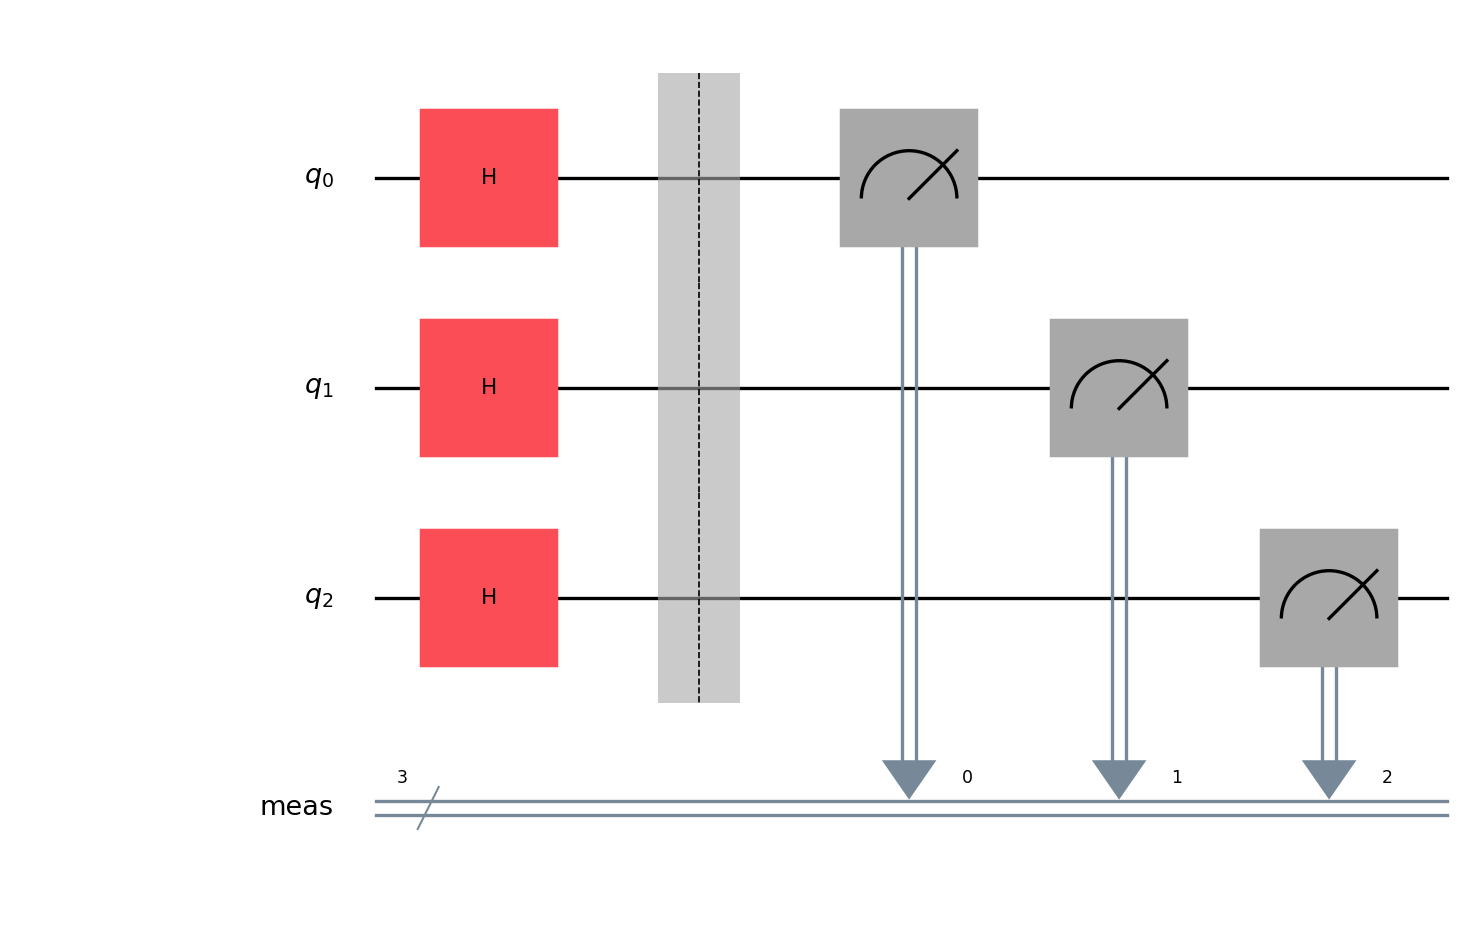

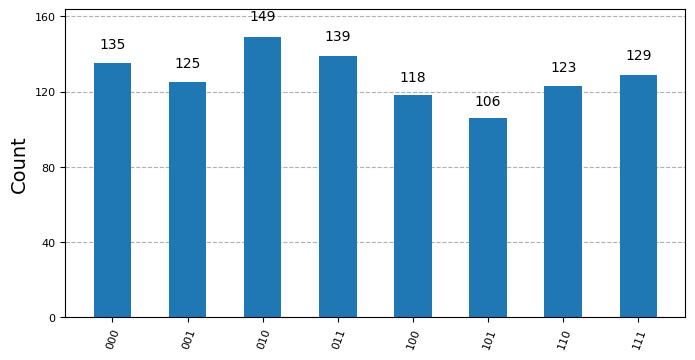

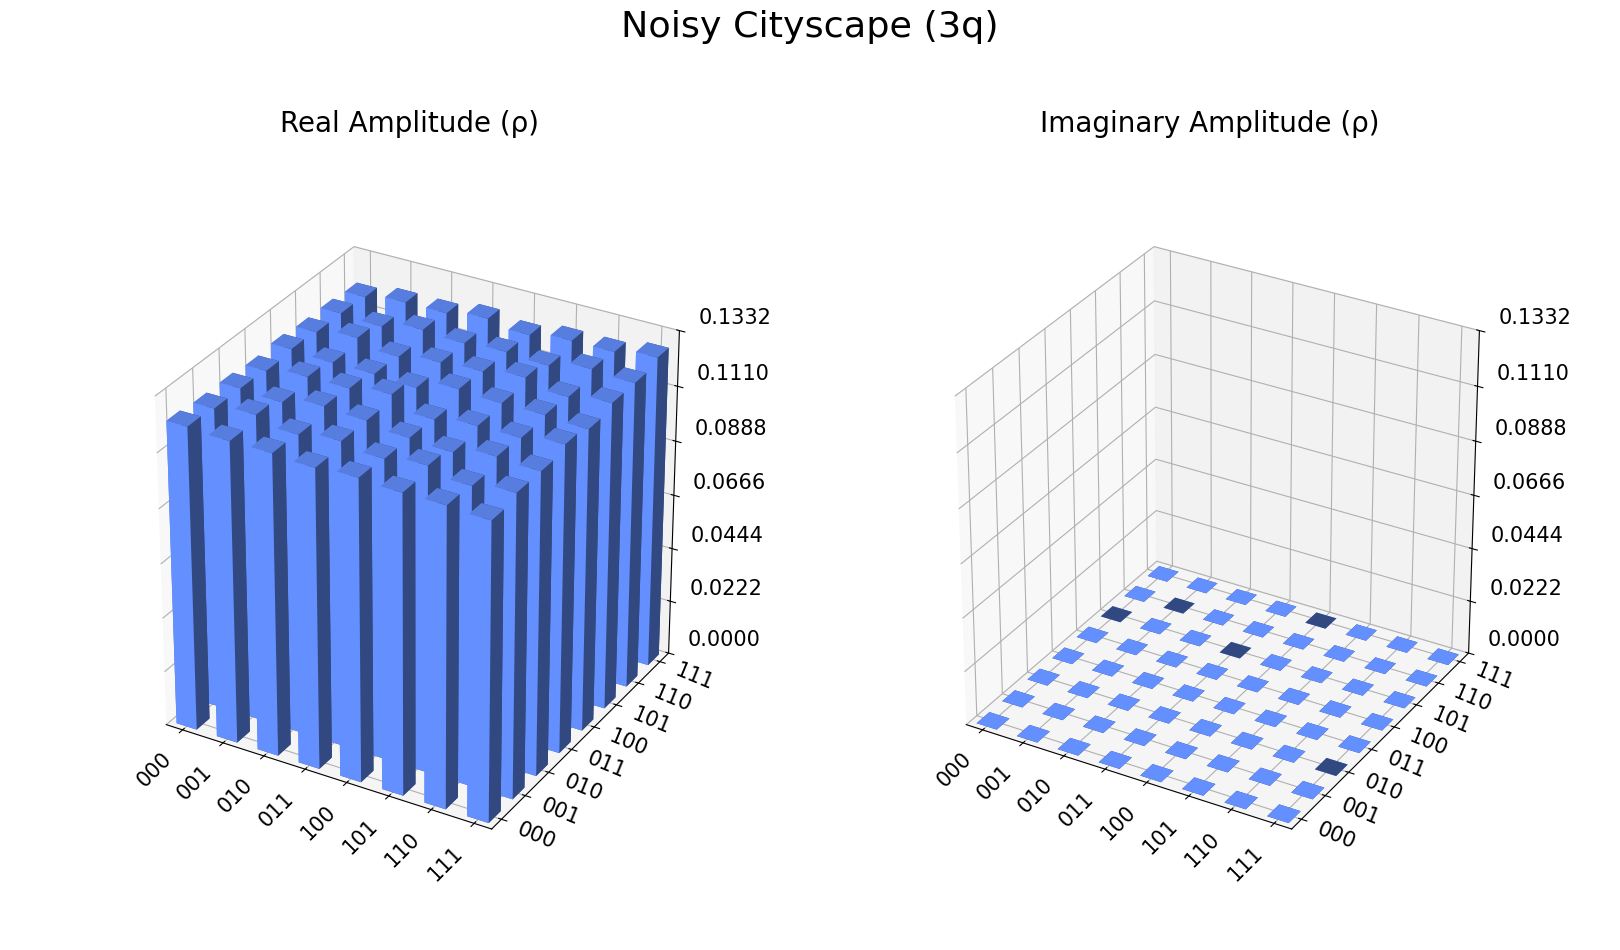

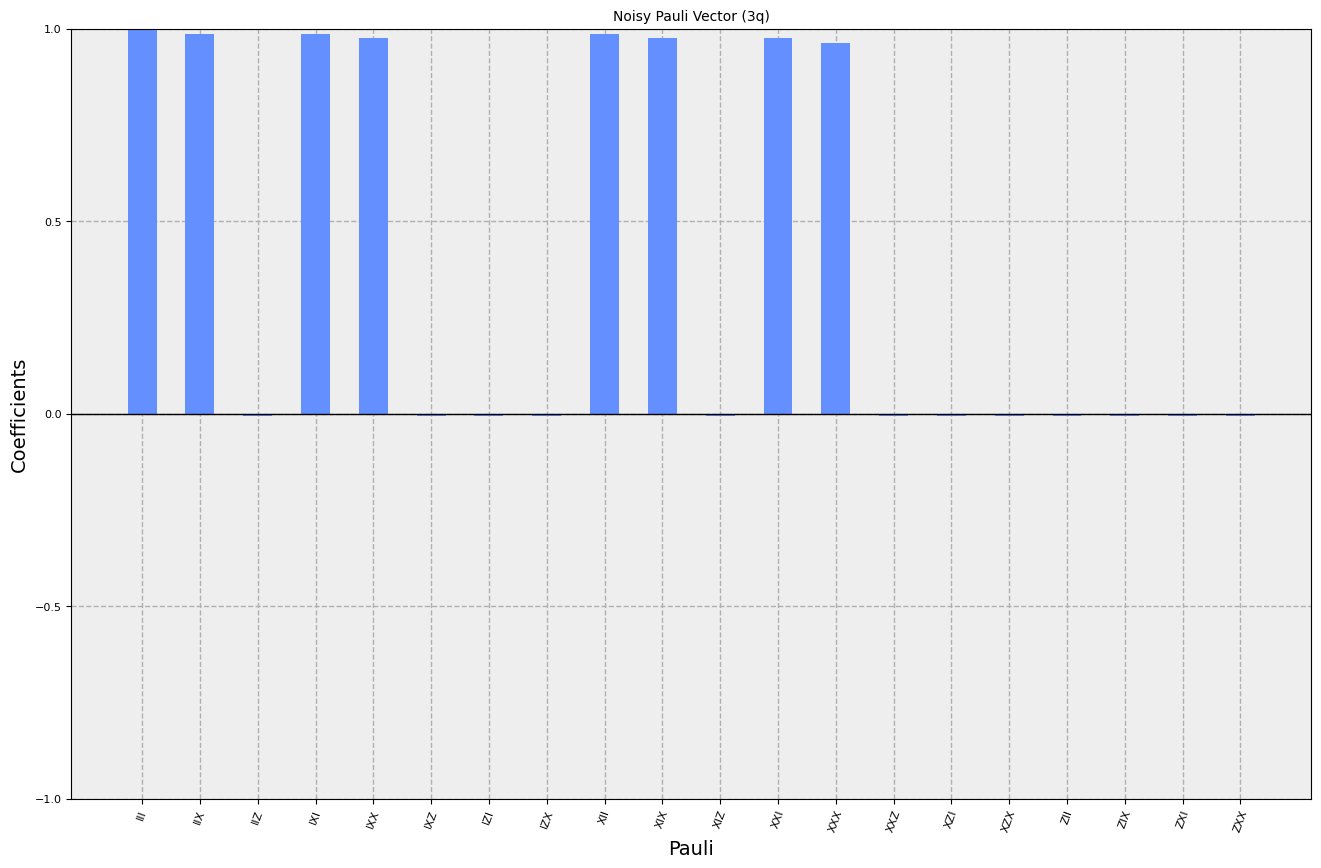

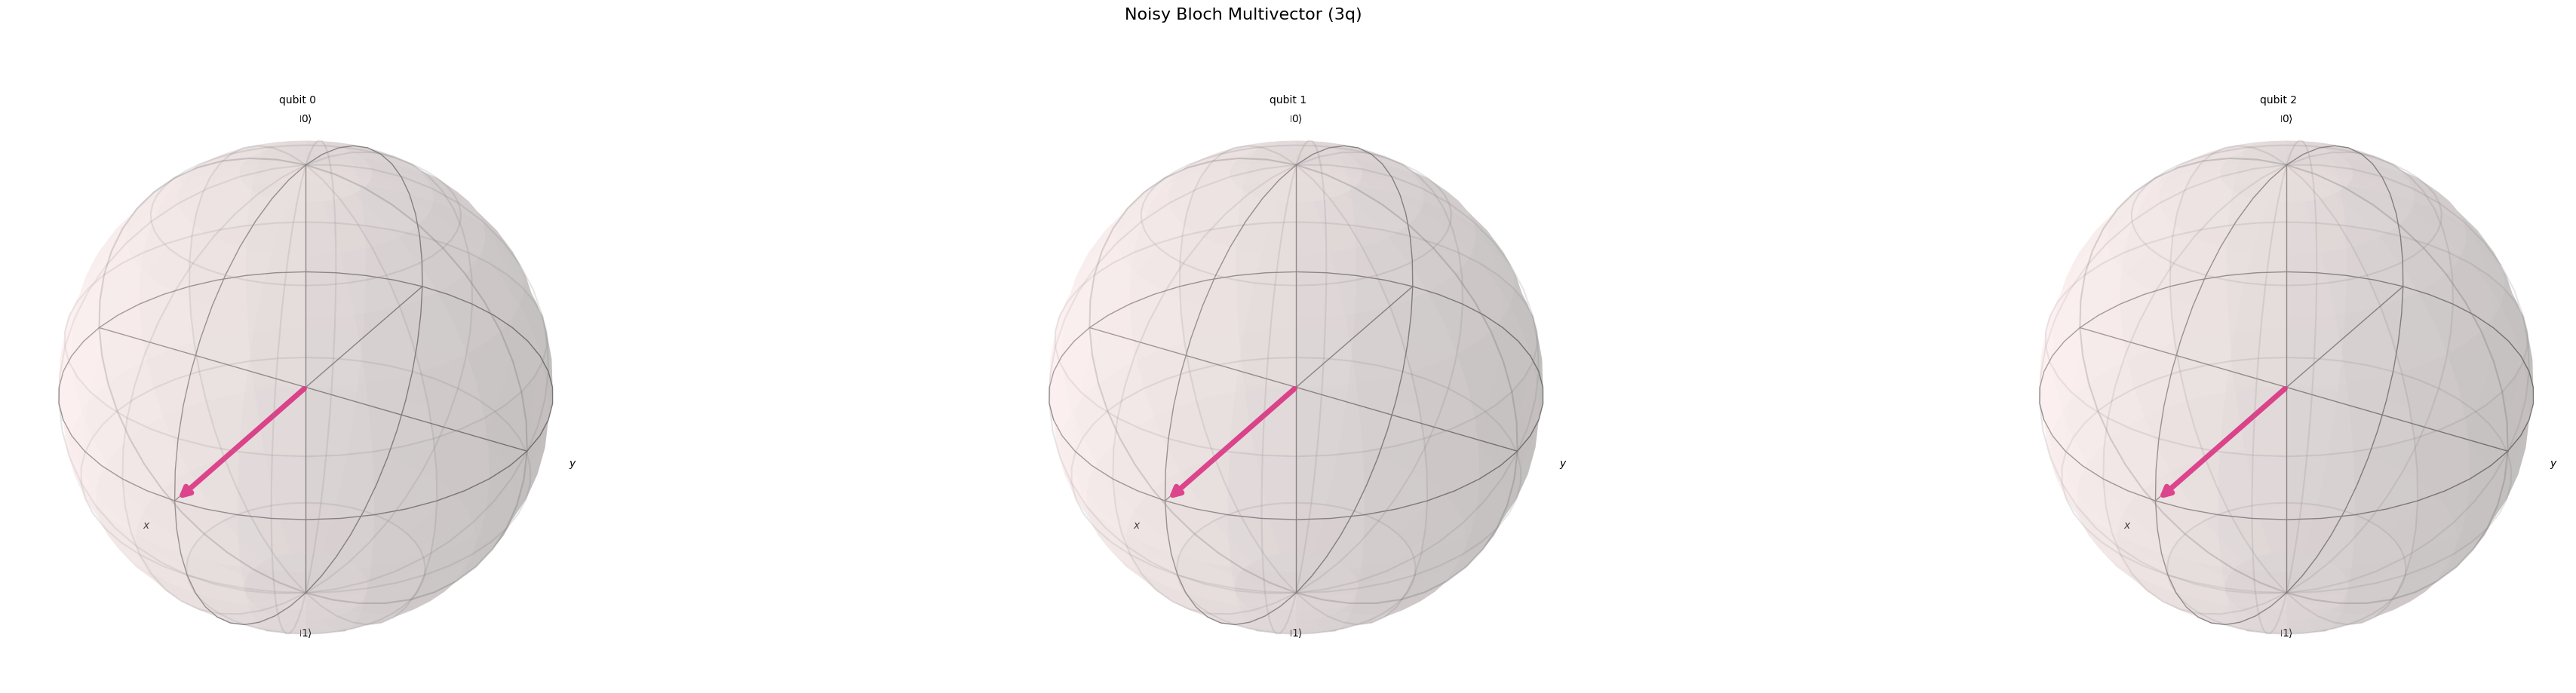

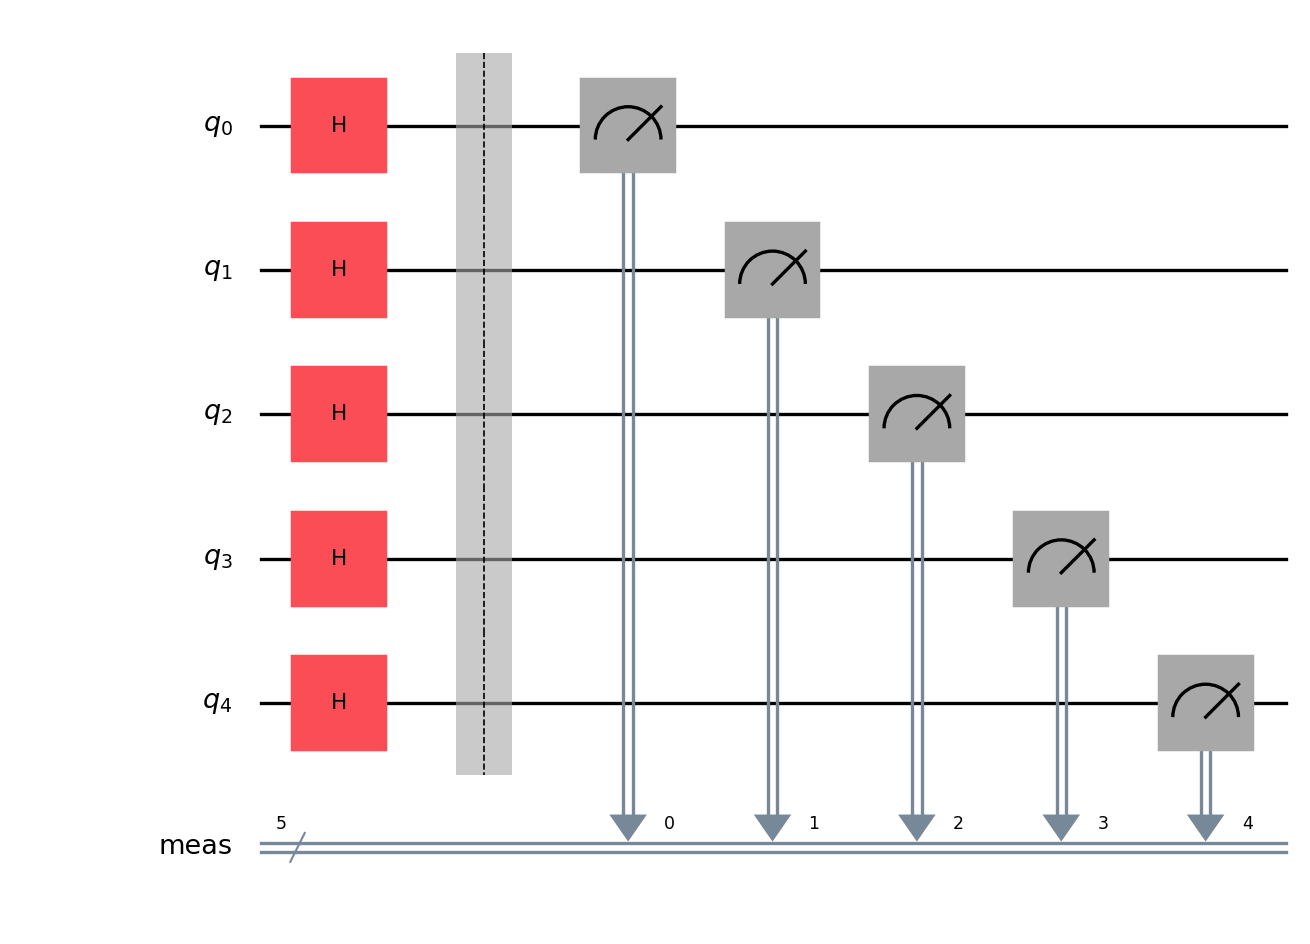

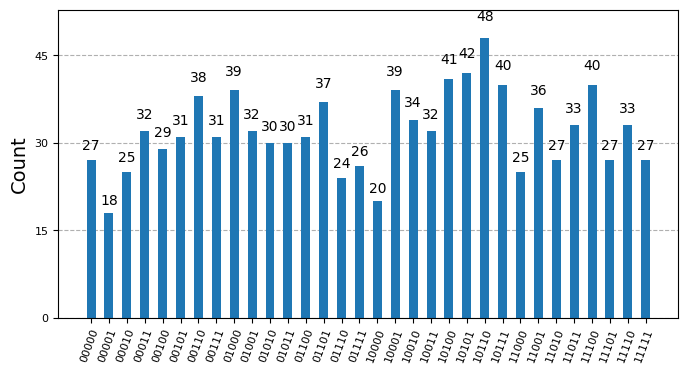

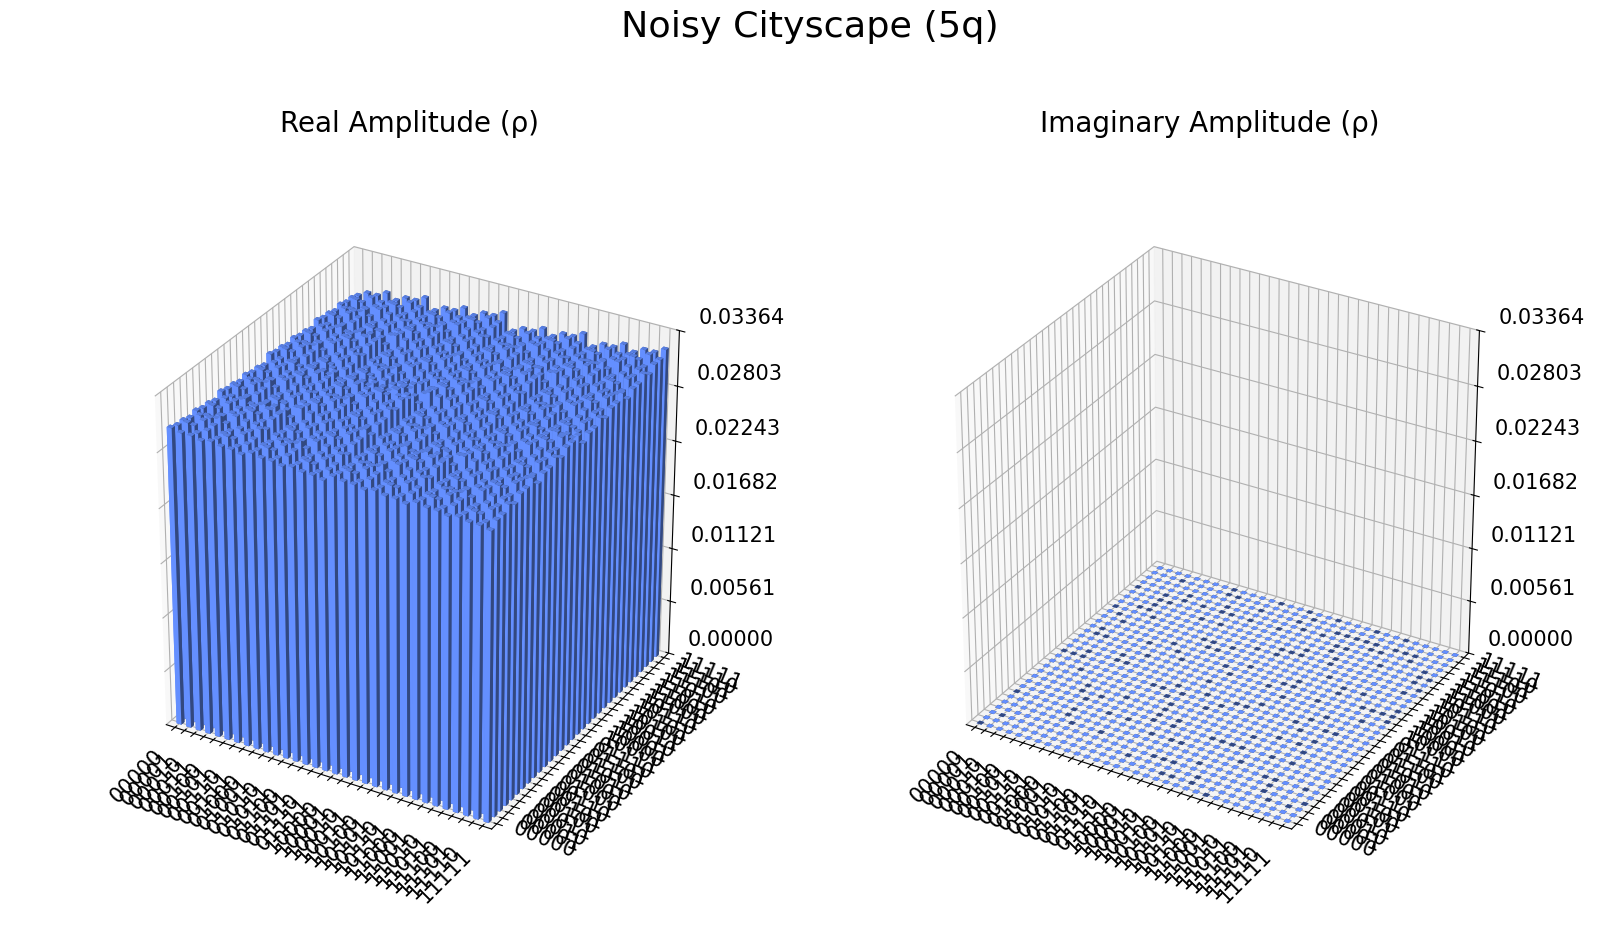

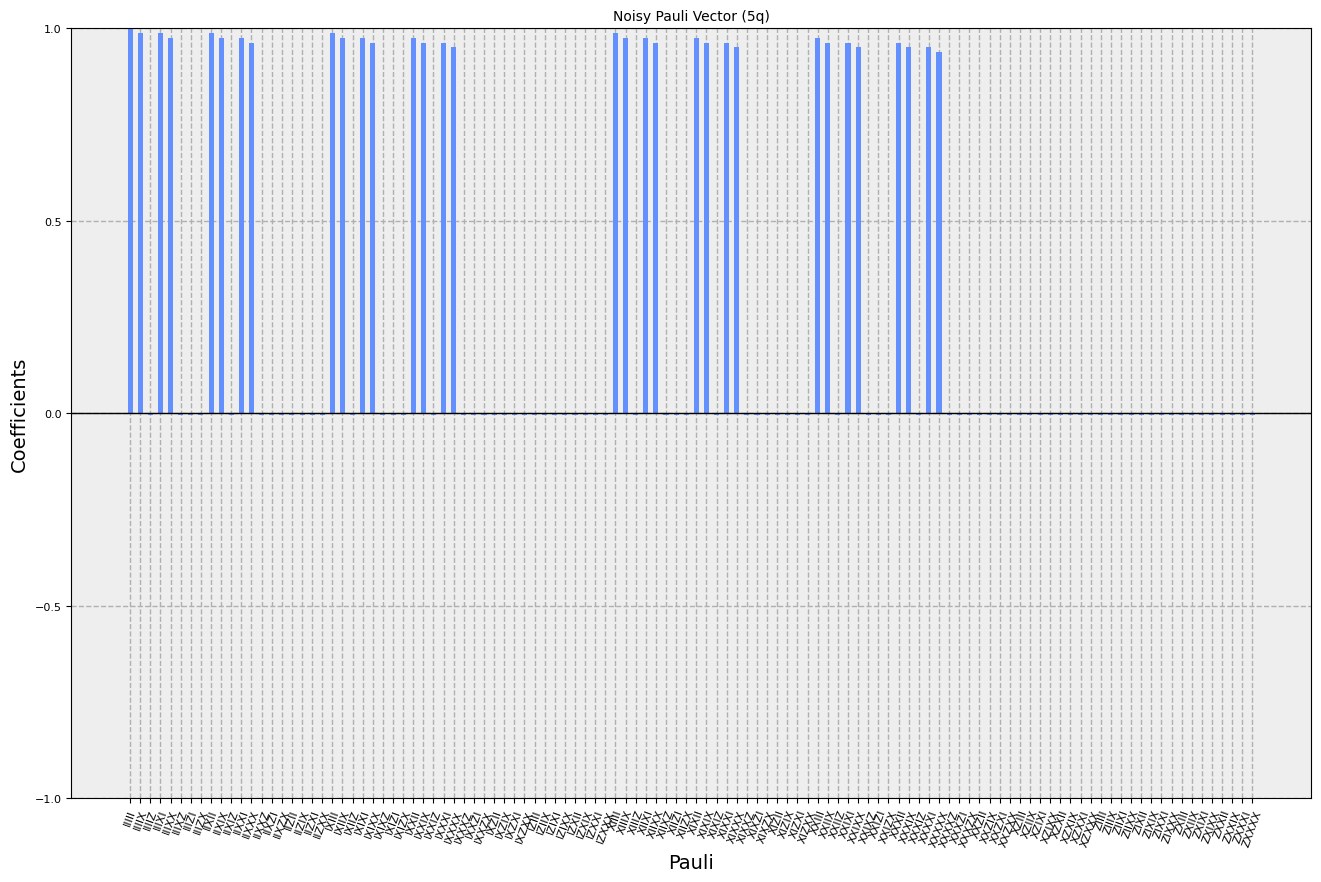

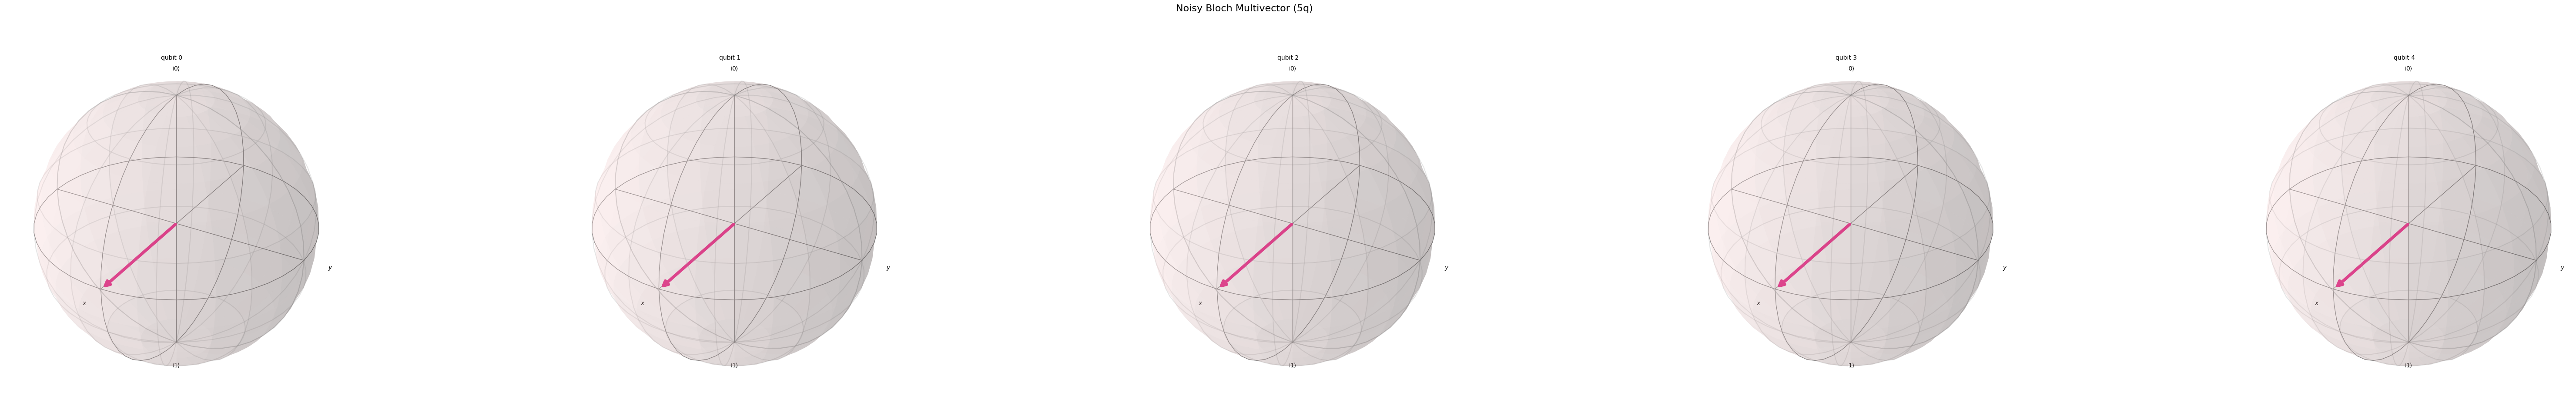

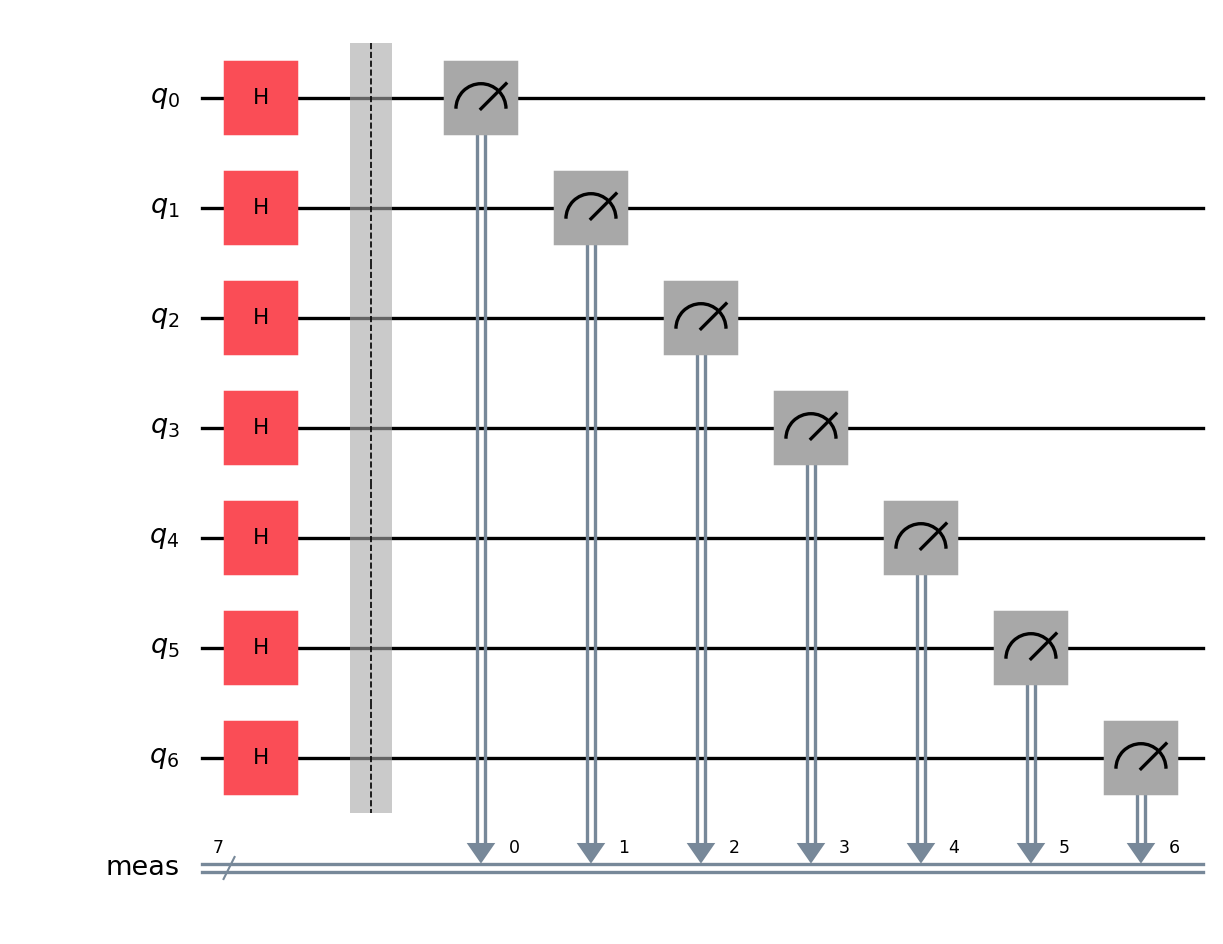

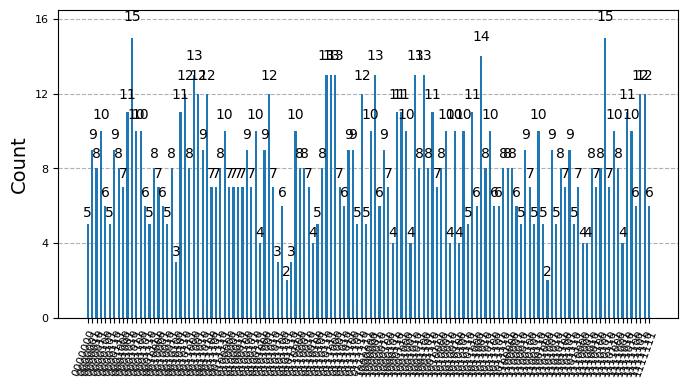

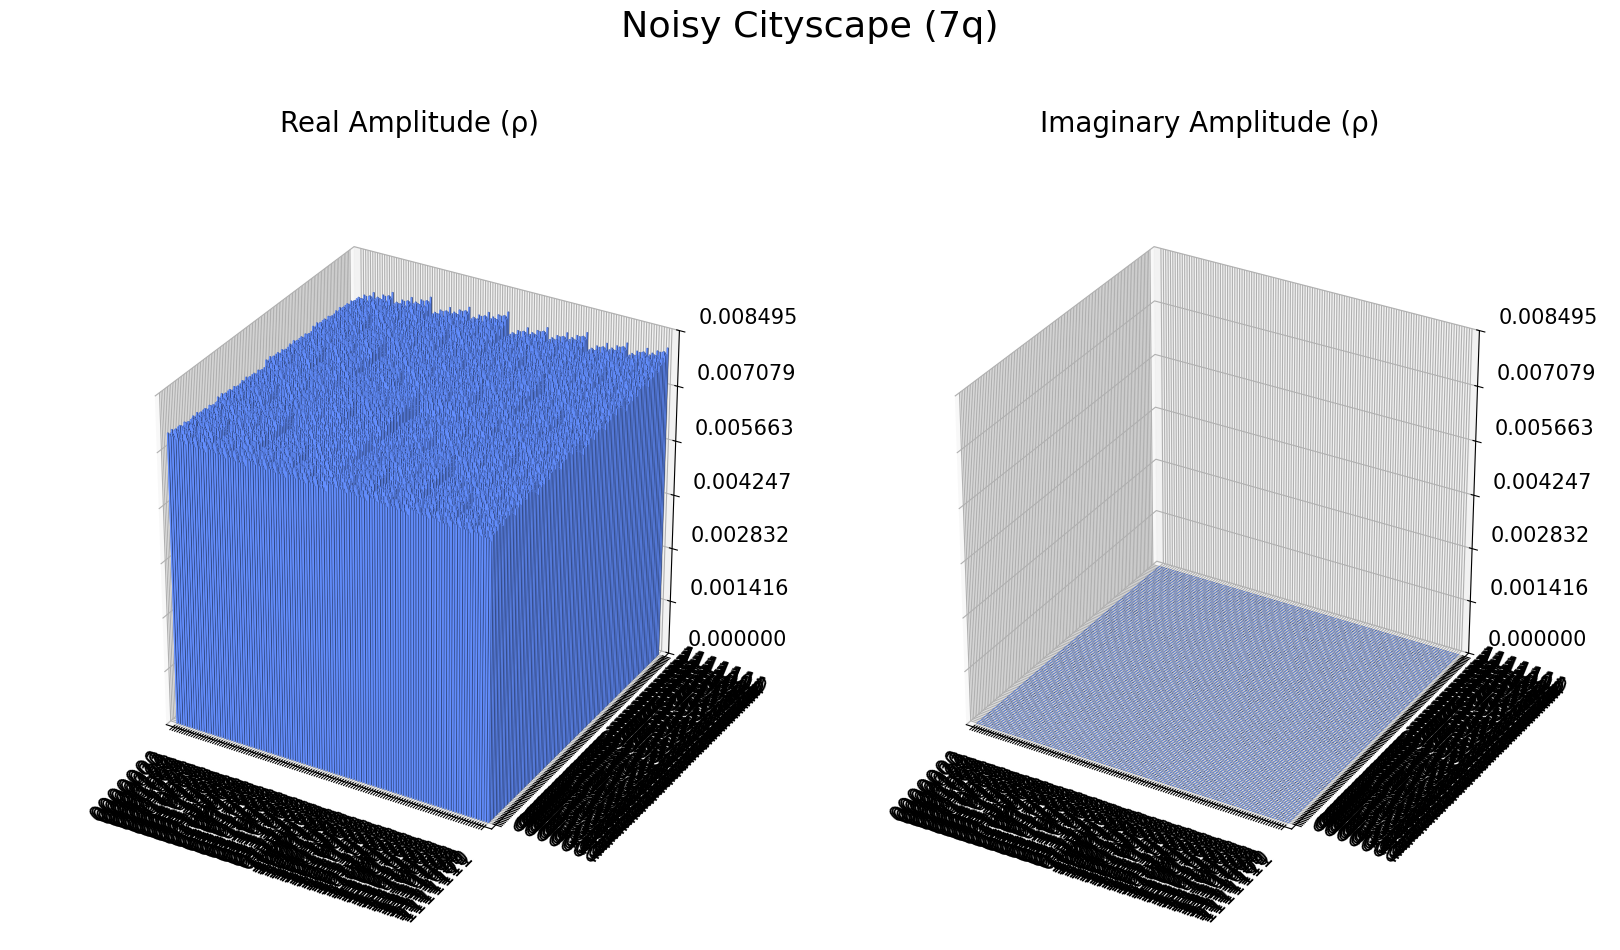

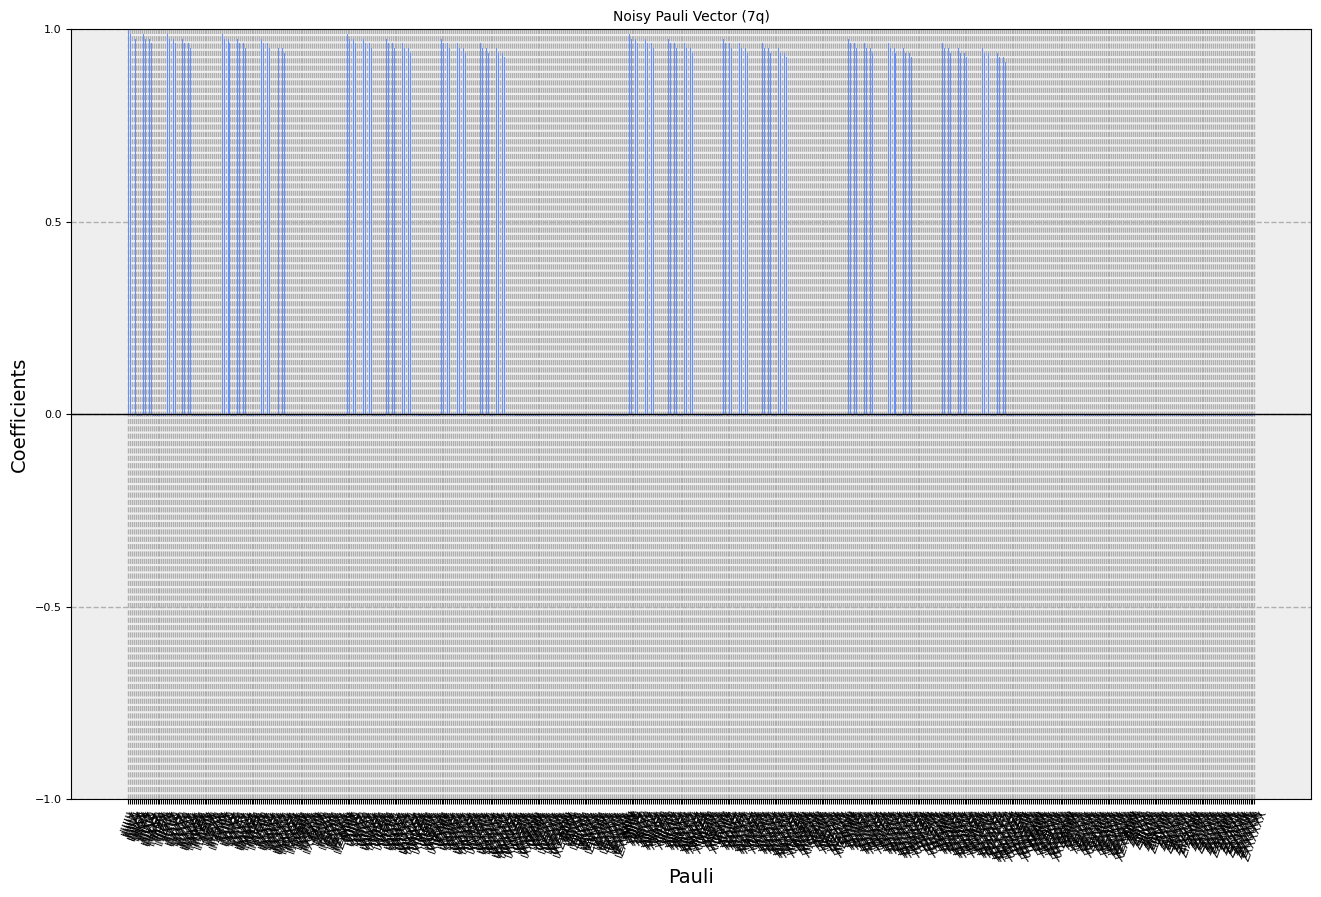

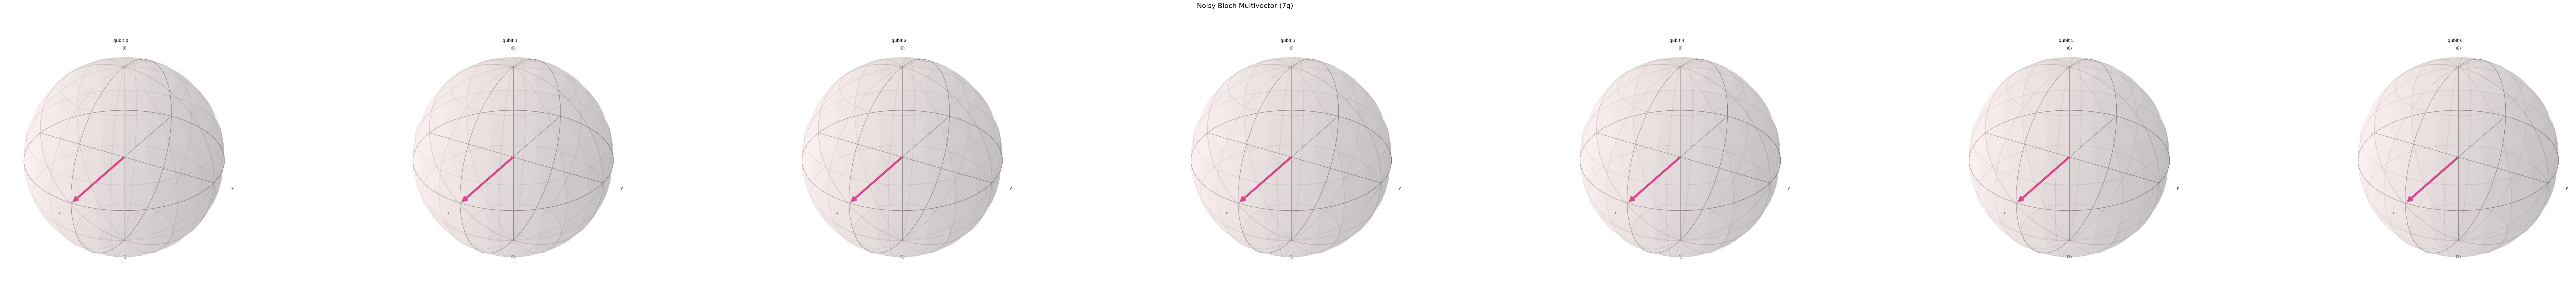

In [ ]:
# Cell 5: Quantum Visualization

for nq in qubit_list:
    Q = QuantumNoise(nq)

    # 5a) Circuit diagram
    fig = Q.qc.draw(output='mpl', scale=1.2)
    fig.set_size_inches(24, 12)
    for ax in fig.axes:
        ax.title.set_fontsize(title_size)
        ax.tick_params(labelsize=tick_size)
    display(fig)

    # 5b) Noisy histogram
    hist_counts = Q.sim.run(Q.qc, shots=1024).result().get_counts()
    fig = plot_histogram(hist_counts, figsize=(8, 4))
    for ax in fig.axes:
        ax.title.set_fontsize(title_size)
        ax.tick_params(labelsize=tick_size)
    display(fig)

    # 5c) Noisy density matrix → Cityscape / Pauli / Bloch
    qc_nom = QuantumCircuit(nq)
    qc_nom.h(range(nq))
    qc_nom.save_density_matrix(label='dm')
    res = Q.sim.run(transpile(qc_nom, Q.sim)).result()
    rho = res.data(0)['dm']

    # Cityscape
    fig = plot_state_city(rho, title=f'Noisy Cityscape ({nq}q)', figsize=(16, 10))
    mval = np.max(np.real(np.diag(rho)))
    # adjust z axis limits
    for ax in fig.axes:
        if hasattr(ax, 'zaxis'):
            ax.set_zlim(0, mval * 1.05)
            ax.zaxis.set_major_locator(mticker.LinearLocator(7))
        # enforce consistent font sizes on title and all tick labels
        ax.title.set_fontsize(20)
        ax.tick_params(labelsize=15)
        # if this axis is a colorbar (no zaxis), adjust its label size too
        if not hasattr(ax, 'zaxis') and ax.get_label() == '<colorbar>':
            ax.yaxis.label.set_size(20)
            ax.tick_params(labelsize=15)
    display(fig)

    # Pauli-vector
    fig = plot_state_paulivec(rho, title=f'Noisy Pauli Vector ({nq}q)', figsize=(16, 10))
    for ax in fig.axes:
        ax.title.set_fontsize(title_size)
        ax.tick_params(labelsize=tick_size)
    display(fig)

    # Bloch multivector
    fig = plot_bloch_multivector(rho, title=f'Noisy Bloch Multivector ({nq}q)', figsize=(16, 10))
    for ax in fig.axes:
        ax.title.set_fontsize(title_size)
        ax.tick_params(labelsize=tick_size)
    display(fig)


In [ ]:
# Cell 6: Training Loops with Logging

def train_qgan(n_qubits, shots_per_sample=None):
    G, D = build_generator(n_qubits), build_discriminator()
    optG, optD = Adam(2e-4), Adam(2e-4)
    Qn = QuantumNoise(n_qubits)
    logs = []
    samples_seen = 0
    shots_per_sample = shots_per_sample or batch_size

    for ep in range(1, epochs+1):
        start = time.time()
        bd, bg = [], []
        quantum_shots = 0

        for real in dataset:
            bs = int(real.shape[0])
            samples_seen += bs
            with tf.GradientTape(persistent=True) as tape:
                dr = bce(tf.ones_like(D(real)), D(real, training=True))

                z = (Qn.sample(shots_per_sample)*2)-1
                quantum_shots += shots_per_sample
                z = tf.convert_to_tensor(z[:bs], dtype=tf.float32)
                fake = G(z, training=True)
                df = bce(tf.zeros_like(D(fake)), D(fake, training=True))
                d_loss = 0.5*(dr + df)

                z2 = (Qn.sample(shots_per_sample)*2)-1
                quantum_shots += shots_per_sample
                z2 = tf.convert_to_tensor(z2[:bs], dtype=tf.float32)
                gen = G(z2, training=True)
                g_loss = bce(tf.ones_like(D(gen)), D(gen, training=False))

            optD.apply_gradients(zip(tape.gradient(d_loss, D.trainable_variables), D.trainable_variables))
            optG.apply_gradients(zip(tape.gradient(g_loss, G.trainable_variables), G.trainable_variables))
            bd.append(d_loss.numpy())
            bg.append(g_loss.numpy())
            del tape

        elapsed = time.time() - start
        d_mean, g_mean = float(np.mean(bd)), float(np.mean(bg))

        # FID & KID
        qz = (Qn.sample(n_fid)*2)-1
        fake_imgs = G.predict(qz, verbose=0).reshape(-1,28,28)
        fake_acts = inception.predict(preprocess_for_inception(fake_imgs), verbose=0)
        fid_val = calculate_fid(mu1, sigma1, fake_imgs)
        kid_val = polynomial_mmd(real_acts, fake_acts)

        if ep % 10 == 0:
            logs.append({
                'epoch': ep,
                'samples_seen': samples_seen,
                'quantum_shots': quantum_shots,
                'time_s': elapsed,
                'd_loss': d_mean,
                'g_loss': g_mean,
                'FID': fid_val,
                'KID': kid_val
            })

        print(f"QGAN {n_qubits}q | Ep {ep:3d} | Samples {samples_seen} | Shots {quantum_shots} | "
              f"Time {elapsed:.2f}s | D={d_mean:.4f} | G={g_mean:.4f} | FID={fid_val:.2f} | KID={kid_val:.4f}")

    pd.DataFrame(logs).to_csv(f"{log_dir}/QGAN_{n_qubits}q_metrics.csv", index=False)
    return G, D, logs

def train_classical_gan(latent_dim=latent_dim_classical):
    Gc, Dc = build_generator(latent_dim), build_discriminator()
    optGc, optDc = Adam(2e-4), Adam(2e-4)
    logs = []
    samples_seen = 0

    for ep in range(1, epochs+1):
        start = time.time()
        bd, bg = [], []

        for real in dataset:
            bs = int(real.shape[0])
            samples_seen += bs
            noise = tf.random.normal([bs, latent_dim])
            with tf.GradientTape(persistent=True) as tape:
                dr = bce(tf.ones_like(Dc(real)), Dc(real, training=True))
                fake = Gc(noise, training=True)
                df = bce(tf.zeros_like(Dc(fake)), Dc(fake, training=True))
                d_loss = 0.5*(dr + df)

                gen = Gc(noise, training=True)
                g_loss = bce(tf.ones_like(Dc(gen)), Dc(gen, training=False))

            optDc.apply_gradients(zip(tape.gradient(d_loss, Dc.trainable_variables), Dc.trainable_variables))
            optGc.apply_gradients(zip(tape.gradient(g_loss, Gc.trainable_variables), Gc.trainable_variables))
            bd.append(d_loss.numpy())
            bg.append(g_loss.numpy())
            del tape

        elapsed = time.time() - start
        d_mean, g_mean = float(np.mean(bd)), float(np.mean(bg))

        # FID & KID
        noise_fid = tf.random.normal([n_fid, latent_dim])
        fake_imgs = Gc.predict(noise_fid, verbose=0).reshape(-1,28,28)
        fake_acts = inception.predict(preprocess_for_inception(fake_imgs), verbose=0)
        fid_val = calculate_fid(mu1, sigma1, fake_imgs)
        kid_val = polynomial_mmd(real_acts, fake_acts)

        if ep % 10 == 0:
            logs.append({
                'epoch': ep,
                'samples_seen': samples_seen,
                'time_s': elapsed,
                'd_loss': d_mean,
                'g_loss': g_mean,
                'FID': fid_val,
                'KID': kid_val
            })

        print(f"Classical | Ep {ep:3d} | Samples {samples_seen} | Time {elapsed:.2f}s | "
              f"D={d_mean:.4f} | G={g_mean:.4f} | FID={fid_val:.2f} | KID={kid_val:.4f}")

    pd.DataFrame(logs).to_csv(f"{log_dir}/ClassicalGAN_metrics.csv", index=False)
    return Gc, Dc, logs


In [ ]:
# Cell 7: Run Experiments

results = {}
for nq in qubit_list:
    _, _, qlogs = train_qgan(nq)
    results[f"{nq} qubits"] = pd.DataFrame(qlogs)

_, _, clogs = train_classical_gan()
results['classical'] = pd.DataFrame(clogs)


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   1 | Samples 11846 | Shots 23808 | Time 25.60s | D=0.2377 | G=1.2140 | FID=409.65 | KID=77638848.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   2 | Samples 23692 | Shots 23808 | Time 24.14s | D=0.0679 | G=2.2079 | FID=461.11 | KID=143959456.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   3 | Samples 35538 | Shots 23808 | Time 24.30s | D=0.0313 | G=3.1232 | FID=533.64 | KID=152177248.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   4 | Samples 47384 | Shots 23808 | Time 24.27s | D=0.0140 | G=4.2925 | FID=636.11 | KID=323647392.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   5 | Samples 59230 | Shots 23808 | Time 24.18s | D=0.0132 | G=4.4740 | FID=597.85 | KID=277543168.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   6 | Samples 71076 | Shots 23808 | Time 24.35s | D=0.0177 | G=4.4149 | FID=524.04 | KID=198102816.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   7 | Samples 82922 | Shots 23808 | Time 24.26s | D=0.0167 | G=4.5633 | FID=404.30 | KID=90902456.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   8 | Samples 94768 | Shots 23808 | Time 24.27s | D=0.0313 | G=4.0488 | FID=406.86 | KID=71298848.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep   9 | Samples 106614 | Shots 23808 | Time 24.27s | D=0.0320 | G=4.0778 | FID=447.14 | KID=135500480.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  10 | Samples 118460 | Shots 23808 | Time 24.18s | D=0.0245 | G=4.2820 | FID=457.97 | KID=165246752.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  11 | Samples 130306 | Shots 23808 | Time 24.31s | D=0.0255 | G=4.2837 | FID=447.51 | KID=141546560.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  12 | Samples 142152 | Shots 23808 | Time 24.15s | D=0.0263 | G=4.3585 | FID=404.25 | KID=115123840.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  13 | Samples 153998 | Shots 23808 | Time 24.34s | D=0.0282 | G=4.4388 | FID=445.41 | KID=132121728.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  14 | Samples 165844 | Shots 23808 | Time 24.25s | D=0.0337 | G=4.3788 | FID=414.31 | KID=123056496.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  15 | Samples 177690 | Shots 23808 | Time 24.36s | D=0.0415 | G=4.3200 | FID=455.49 | KID=115574920.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  16 | Samples 189536 | Shots 23808 | Time 24.17s | D=0.0415 | G=4.2138 | FID=470.09 | KID=116997024.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  17 | Samples 201382 | Shots 23808 | Time 24.45s | D=0.0454 | G=4.2536 | FID=437.03 | KID=103656304.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  18 | Samples 213228 | Shots 23808 | Time 24.43s | D=0.0403 | G=4.0253 | FID=529.69 | KID=155365664.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  19 | Samples 225074 | Shots 23808 | Time 24.13s | D=0.0436 | G=4.3226 | FID=433.60 | KID=98508832.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  20 | Samples 236920 | Shots 23808 | Time 23.82s | D=0.0433 | G=4.1413 | FID=437.13 | KID=120091520.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  21 | Samples 248766 | Shots 23808 | Time 24.44s | D=0.0483 | G=3.6982 | FID=414.35 | KID=87694592.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  22 | Samples 260612 | Shots 23808 | Time 24.43s | D=0.0440 | G=4.0569 | FID=422.26 | KID=108435488.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  23 | Samples 272458 | Shots 23808 | Time 24.30s | D=0.0408 | G=4.1260 | FID=435.68 | KID=123107488.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  24 | Samples 284304 | Shots 23808 | Time 24.23s | D=0.0511 | G=4.6106 | FID=453.78 | KID=106078608.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  25 | Samples 296150 | Shots 23808 | Time 24.34s | D=0.0293 | G=4.5827 | FID=449.97 | KID=124533472.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  26 | Samples 307996 | Shots 23808 | Time 24.22s | D=0.0271 | G=4.5153 | FID=465.38 | KID=105217648.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  27 | Samples 319842 | Shots 23808 | Time 24.26s | D=0.0323 | G=4.7495 | FID=450.58 | KID=131410800.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  28 | Samples 331688 | Shots 23808 | Time 24.35s | D=0.0509 | G=4.5032 | FID=405.54 | KID=108102176.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  29 | Samples 343534 | Shots 23808 | Time 24.15s | D=0.0611 | G=4.5649 | FID=408.02 | KID=94213072.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  30 | Samples 355380 | Shots 23808 | Time 24.27s | D=0.0565 | G=4.8607 | FID=405.27 | KID=99406960.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  31 | Samples 367226 | Shots 23808 | Time 24.20s | D=0.0334 | G=4.2953 | FID=558.49 | KID=204138368.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  32 | Samples 379072 | Shots 23808 | Time 24.17s | D=0.0209 | G=4.9281 | FID=478.74 | KID=144303184.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  33 | Samples 390918 | Shots 23808 | Time 24.32s | D=0.0455 | G=4.4885 | FID=376.02 | KID=85555968.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  34 | Samples 402764 | Shots 23808 | Time 24.21s | D=0.0639 | G=4.4705 | FID=348.92 | KID=79221264.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  35 | Samples 414610 | Shots 23808 | Time 24.17s | D=0.0592 | G=4.4024 | FID=371.54 | KID=84812680.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  36 | Samples 426456 | Shots 23808 | Time 24.34s | D=0.0441 | G=4.2158 | FID=395.18 | KID=91273472.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  37 | Samples 438302 | Shots 23808 | Time 24.22s | D=0.0347 | G=5.2276 | FID=393.94 | KID=125966704.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  38 | Samples 450148 | Shots 23808 | Time 24.22s | D=0.0268 | G=4.6848 | FID=364.66 | KID=79622240.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  39 | Samples 461994 | Shots 23808 | Time 23.93s | D=0.0229 | G=4.7513 | FID=460.86 | KID=115463200.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  40 | Samples 473840 | Shots 23808 | Time 24.40s | D=0.0214 | G=4.5828 | FID=458.29 | KID=129206768.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  41 | Samples 485686 | Shots 23808 | Time 24.26s | D=0.0242 | G=4.9861 | FID=398.29 | KID=84016456.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  42 | Samples 497532 | Shots 23808 | Time 24.22s | D=0.0610 | G=6.2711 | FID=344.05 | KID=84405168.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  43 | Samples 509378 | Shots 23808 | Time 24.10s | D=0.0686 | G=4.5237 | FID=387.06 | KID=114096016.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  44 | Samples 521224 | Shots 23808 | Time 24.17s | D=0.0389 | G=4.1483 | FID=439.23 | KID=135578032.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  45 | Samples 533070 | Shots 23808 | Time 24.27s | D=0.0310 | G=4.2913 | FID=457.11 | KID=143052192.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  46 | Samples 544916 | Shots 23808 | Time 24.11s | D=0.0235 | G=4.6447 | FID=427.67 | KID=125027840.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  47 | Samples 556762 | Shots 23808 | Time 24.28s | D=0.0267 | G=5.0766 | FID=397.15 | KID=110798128.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  48 | Samples 568608 | Shots 23808 | Time 23.94s | D=0.0797 | G=6.0201 | FID=350.76 | KID=78070832.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  49 | Samples 580454 | Shots 23808 | Time 24.16s | D=0.0452 | G=4.7375 | FID=361.35 | KID=93311216.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  50 | Samples 592300 | Shots 23808 | Time 24.17s | D=0.0940 | G=5.9821 | FID=347.62 | KID=82375176.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  51 | Samples 604146 | Shots 23808 | Time 24.32s | D=0.0509 | G=4.3371 | FID=375.23 | KID=95374384.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  52 | Samples 615992 | Shots 23808 | Time 24.28s | D=0.0374 | G=4.6357 | FID=393.90 | KID=102565136.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  53 | Samples 627838 | Shots 23808 | Time 24.39s | D=0.0267 | G=5.3302 | FID=439.27 | KID=147865424.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  54 | Samples 639684 | Shots 23808 | Time 24.12s | D=0.0238 | G=5.3376 | FID=433.81 | KID=132022656.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  55 | Samples 651530 | Shots 23808 | Time 24.24s | D=0.0284 | G=5.2342 | FID=444.98 | KID=116267680.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  56 | Samples 663376 | Shots 23808 | Time 24.30s | D=0.0363 | G=5.6709 | FID=368.85 | KID=75081472.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  57 | Samples 675222 | Shots 23808 | Time 24.04s | D=0.0376 | G=5.8429 | FID=361.37 | KID=74900704.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  58 | Samples 687068 | Shots 23808 | Time 24.11s | D=0.0303 | G=4.9960 | FID=374.11 | KID=91448928.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  59 | Samples 698914 | Shots 23808 | Time 24.14s | D=0.0331 | G=6.3571 | FID=357.54 | KID=97320552.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  60 | Samples 710760 | Shots 23808 | Time 24.15s | D=0.0249 | G=5.1581 | FID=388.85 | KID=109203896.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  61 | Samples 722606 | Shots 23808 | Time 24.30s | D=0.0239 | G=5.3032 | FID=367.71 | KID=79313296.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  62 | Samples 734452 | Shots 23808 | Time 24.02s | D=0.0351 | G=6.6152 | FID=423.30 | KID=105613048.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  63 | Samples 746298 | Shots 23808 | Time 24.09s | D=0.0255 | G=6.2306 | FID=414.63 | KID=103623200.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  64 | Samples 758144 | Shots 23808 | Time 24.16s | D=0.0303 | G=5.4321 | FID=366.32 | KID=93900272.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  65 | Samples 769990 | Shots 23808 | Time 24.23s | D=0.0337 | G=6.6752 | FID=340.60 | KID=73844752.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  66 | Samples 781836 | Shots 23808 | Time 24.17s | D=0.0762 | G=7.1455 | FID=344.95 | KID=95320608.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  67 | Samples 793682 | Shots 23808 | Time 24.03s | D=0.0368 | G=5.4157 | FID=373.17 | KID=108454352.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  68 | Samples 805528 | Shots 23808 | Time 24.33s | D=0.0383 | G=6.3577 | FID=390.11 | KID=94696584.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  69 | Samples 817374 | Shots 23808 | Time 24.25s | D=0.0271 | G=5.4999 | FID=389.43 | KID=88683016.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  70 | Samples 829220 | Shots 23808 | Time 24.01s | D=0.0184 | G=5.8074 | FID=396.41 | KID=95989296.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  71 | Samples 841066 | Shots 23808 | Time 24.16s | D=0.0207 | G=6.8693 | FID=382.04 | KID=126628016.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  72 | Samples 852912 | Shots 23808 | Time 24.13s | D=0.0450 | G=6.4172 | FID=349.31 | KID=83746120.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  73 | Samples 864758 | Shots 23808 | Time 24.21s | D=0.0490 | G=5.8190 | FID=343.12 | KID=76622368.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  74 | Samples 876604 | Shots 23808 | Time 24.16s | D=0.0472 | G=6.3816 | FID=361.96 | KID=86383536.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  75 | Samples 888450 | Shots 23808 | Time 24.18s | D=0.0425 | G=5.6352 | FID=379.55 | KID=96264000.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  76 | Samples 900296 | Shots 23808 | Time 24.00s | D=0.0360 | G=4.8455 | FID=374.53 | KID=113956144.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  77 | Samples 912142 | Shots 23808 | Time 24.24s | D=0.1075 | G=8.9990 | FID=347.74 | KID=76730304.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  78 | Samples 923988 | Shots 23808 | Time 24.11s | D=0.1341 | G=5.8062 | FID=340.13 | KID=65484276.0000
QGAN 3q | Ep  79 | Samples 935834 | Shots 23808 | Time 24.16s | D=0.0680 | G=4.9192 | FID=369.05 | KID=88341328.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  80 | Samples 947680 | Shots 23808 | Time 24.10s | D=0.0436 | G=4.3783 | FID=384.30 | KID=94572152.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  81 | Samples 959526 | Shots 23808 | Time 24.16s | D=0.0427 | G=4.6660 | FID=350.93 | KID=84323712.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  82 | Samples 971372 | Shots 23808 | Time 24.08s | D=0.0413 | G=4.5270 | FID=353.79 | KID=91338608.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  83 | Samples 983218 | Shots 23808 | Time 24.20s | D=0.0484 | G=4.8223 | FID=353.84 | KID=86282048.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  84 | Samples 995064 | Shots 23808 | Time 24.22s | D=0.0579 | G=5.3388 | FID=308.71 | KID=64035404.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  85 | Samples 1006910 | Shots 23808 | Time 24.50s | D=0.0523 | G=4.7313 | FID=344.24 | KID=70696064.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  86 | Samples 1018756 | Shots 23808 | Time 23.93s | D=0.0475 | G=5.5227 | FID=344.37 | KID=74761568.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  87 | Samples 1030602 | Shots 23808 | Time 24.19s | D=0.0377 | G=4.8157 | FID=321.16 | KID=72037480.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  88 | Samples 1042448 | Shots 23808 | Time 23.98s | D=0.0323 | G=4.8645 | FID=375.60 | KID=88174944.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  89 | Samples 1054294 | Shots 23808 | Time 24.26s | D=0.0268 | G=5.5342 | FID=360.98 | KID=84600168.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  90 | Samples 1066140 | Shots 23808 | Time 24.13s | D=0.0288 | G=5.8923 | FID=379.55 | KID=93369552.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  91 | Samples 1077986 | Shots 23808 | Time 24.21s | D=0.0308 | G=5.9880 | FID=344.67 | KID=88606144.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  92 | Samples 1089832 | Shots 23808 | Time 24.03s | D=0.0358 | G=5.3712 | FID=325.58 | KID=84451792.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  93 | Samples 1101678 | Shots 23808 | Time 24.33s | D=0.0744 | G=8.5660 | FID=323.71 | KID=60825468.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  94 | Samples 1113524 | Shots 23808 | Time 24.07s | D=0.0645 | G=5.0361 | FID=369.26 | KID=102552736.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  95 | Samples 1125370 | Shots 23808 | Time 23.85s | D=0.0353 | G=5.3404 | FID=381.29 | KID=89040640.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  96 | Samples 1137216 | Shots 23808 | Time 24.22s | D=0.0351 | G=6.5262 | FID=364.65 | KID=78533352.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  97 | Samples 1149062 | Shots 23808 | Time 24.35s | D=0.0270 | G=4.8357 | FID=385.57 | KID=95716080.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  98 | Samples 1160908 | Shots 23808 | Time 24.10s | D=0.0251 | G=6.2555 | FID=400.80 | KID=108595888.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep  99 | Samples 1172754 | Shots 23808 | Time 24.18s | D=0.0187 | G=6.1071 | FID=394.50 | KID=100020192.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 100 | Samples 1184600 | Shots 23808 | Time 24.05s | D=0.0209 | G=6.1299 | FID=390.90 | KID=105103680.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 101 | Samples 1196446 | Shots 23808 | Time 24.35s | D=0.0285 | G=6.9227 | FID=373.34 | KID=102854864.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 102 | Samples 1208292 | Shots 23808 | Time 24.33s | D=0.0561 | G=8.7685 | FID=308.75 | KID=69496040.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 103 | Samples 1220138 | Shots 23808 | Time 23.89s | D=0.0788 | G=6.7230 | FID=326.85 | KID=56362960.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 104 | Samples 1231984 | Shots 23808 | Time 24.08s | D=0.0576 | G=6.5087 | FID=371.71 | KID=105946384.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 105 | Samples 1243830 | Shots 23808 | Time 24.33s | D=0.0359 | G=5.1593 | FID=399.52 | KID=103213176.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 106 | Samples 1255676 | Shots 23808 | Time 24.08s | D=0.0308 | G=5.3809 | FID=363.35 | KID=71975088.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 107 | Samples 1267522 | Shots 23808 | Time 24.19s | D=0.0363 | G=5.5775 | FID=383.63 | KID=90376520.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 108 | Samples 1279368 | Shots 23808 | Time 24.08s | D=0.0780 | G=8.1969 | FID=336.55 | KID=81783416.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 109 | Samples 1291214 | Shots 23808 | Time 24.21s | D=0.0499 | G=5.1215 | FID=345.18 | KID=87619712.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 110 | Samples 1303060 | Shots 23808 | Time 24.14s | D=0.0413 | G=5.3969 | FID=361.70 | KID=102071808.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 111 | Samples 1314906 | Shots 23808 | Time 23.97s | D=0.0488 | G=6.3732 | FID=353.56 | KID=90599536.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 112 | Samples 1326752 | Shots 23808 | Time 23.96s | D=0.0372 | G=5.4749 | FID=376.06 | KID=96085712.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 113 | Samples 1338598 | Shots 23808 | Time 24.21s | D=0.0380 | G=5.8402 | FID=384.77 | KID=97603960.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 114 | Samples 1350444 | Shots 23808 | Time 23.79s | D=0.0324 | G=5.2209 | FID=354.99 | KID=79227584.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 115 | Samples 1362290 | Shots 23808 | Time 24.09s | D=0.0383 | G=5.7088 | FID=345.41 | KID=91638736.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 116 | Samples 1374136 | Shots 23808 | Time 24.08s | D=0.0773 | G=8.1279 | FID=309.80 | KID=59395224.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 117 | Samples 1385982 | Shots 23808 | Time 24.20s | D=0.0832 | G=6.7086 | FID=361.28 | KID=81047360.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 118 | Samples 1397828 | Shots 23808 | Time 24.21s | D=0.0524 | G=5.5174 | FID=366.35 | KID=86011424.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 119 | Samples 1409674 | Shots 23808 | Time 24.19s | D=0.0427 | G=5.1908 | FID=378.41 | KID=105035928.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 120 | Samples 1421520 | Shots 23808 | Time 23.99s | D=0.0344 | G=5.5476 | FID=416.50 | KID=103166560.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 121 | Samples 1433366 | Shots 23808 | Time 24.23s | D=0.0325 | G=5.5048 | FID=368.22 | KID=85729376.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 122 | Samples 1445212 | Shots 23808 | Time 24.10s | D=0.0317 | G=4.9938 | FID=365.44 | KID=91557640.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 123 | Samples 1457058 | Shots 23808 | Time 23.76s | D=0.0534 | G=6.8460 | FID=382.25 | KID=94452880.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 124 | Samples 1468904 | Shots 23808 | Time 24.18s | D=0.0610 | G=5.9215 | FID=338.68 | KID=80065352.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 125 | Samples 1480750 | Shots 23808 | Time 24.49s | D=0.0605 | G=5.5062 | FID=341.26 | KID=76559808.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 126 | Samples 1492596 | Shots 23808 | Time 24.09s | D=0.0587 | G=7.4531 | FID=353.49 | KID=80632208.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 127 | Samples 1504442 | Shots 23808 | Time 24.09s | D=0.0425 | G=4.9459 | FID=357.03 | KID=82094224.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 128 | Samples 1516288 | Shots 23808 | Time 24.02s | D=0.0368 | G=5.2421 | FID=379.44 | KID=95306912.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 129 | Samples 1528134 | Shots 23808 | Time 24.18s | D=0.0266 | G=5.3197 | FID=435.33 | KID=138092928.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 130 | Samples 1539980 | Shots 23808 | Time 24.19s | D=0.0378 | G=7.6033 | FID=352.04 | KID=81694736.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 131 | Samples 1551826 | Shots 23808 | Time 24.02s | D=0.0729 | G=6.7321 | FID=302.22 | KID=69192808.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 132 | Samples 1563672 | Shots 23808 | Time 24.06s | D=0.1003 | G=5.8786 | FID=319.38 | KID=84906248.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 133 | Samples 1575518 | Shots 23808 | Time 24.18s | D=0.1241 | G=5.8754 | FID=299.29 | KID=81202408.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 134 | Samples 1587364 | Shots 23808 | Time 24.12s | D=0.1350 | G=5.3731 | FID=322.08 | KID=82368560.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 135 | Samples 1599210 | Shots 23808 | Time 24.05s | D=0.0665 | G=4.6630 | FID=326.71 | KID=63586444.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 136 | Samples 1611056 | Shots 23808 | Time 24.13s | D=0.0563 | G=4.4679 | FID=325.74 | KID=73494576.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 137 | Samples 1622902 | Shots 23808 | Time 24.16s | D=0.0702 | G=4.2427 | FID=333.20 | KID=87210272.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 138 | Samples 1634748 | Shots 23808 | Time 24.30s | D=0.0646 | G=4.5941 | FID=348.14 | KID=95920480.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 139 | Samples 1646594 | Shots 23808 | Time 24.24s | D=0.0658 | G=4.3410 | FID=322.42 | KID=81170760.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 140 | Samples 1658440 | Shots 23808 | Time 24.06s | D=0.0715 | G=5.0138 | FID=282.20 | KID=52239080.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 141 | Samples 1670286 | Shots 23808 | Time 24.18s | D=0.0691 | G=4.7572 | FID=300.56 | KID=60293564.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 142 | Samples 1682132 | Shots 23808 | Time 24.41s | D=0.0480 | G=4.3788 | FID=336.17 | KID=97185832.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 143 | Samples 1693978 | Shots 23808 | Time 24.00s | D=0.0602 | G=5.1250 | FID=347.47 | KID=98255840.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 144 | Samples 1705824 | Shots 23808 | Time 24.11s | D=0.0560 | G=5.1799 | FID=338.14 | KID=78342304.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 145 | Samples 1717670 | Shots 23808 | Time 24.15s | D=0.0446 | G=4.7252 | FID=357.87 | KID=90332376.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 146 | Samples 1729516 | Shots 23808 | Time 24.06s | D=0.0388 | G=5.4159 | FID=409.66 | KID=110872672.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 147 | Samples 1741362 | Shots 23808 | Time 24.07s | D=0.0325 | G=5.5587 | FID=351.70 | KID=80839576.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 148 | Samples 1753208 | Shots 23808 | Time 24.23s | D=0.0249 | G=5.0636 | FID=337.71 | KID=72175808.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 149 | Samples 1765054 | Shots 23808 | Time 24.20s | D=0.0302 | G=5.0406 | FID=297.81 | KID=63598624.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 3q | Ep 150 | Samples 1776900 | Shots 23808 | Time 24.31s | D=0.0459 | G=7.2868 | FID=330.17 | KID=77025152.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   1 | Samples 11846 | Shots 23808 | Time 24.08s | D=0.2177 | G=1.2929 | FID=432.38 | KID=86302672.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   2 | Samples 23692 | Shots 23808 | Time 24.26s | D=0.0834 | G=2.0203 | FID=453.13 | KID=110297936.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   3 | Samples 35538 | Shots 23808 | Time 24.15s | D=0.0323 | G=3.1687 | FID=565.74 | KID=202888432.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   4 | Samples 47384 | Shots 23808 | Time 24.14s | D=0.0154 | G=4.1497 | FID=669.90 | KID=397264896.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   5 | Samples 59230 | Shots 23808 | Time 24.21s | D=0.0132 | G=4.5543 | FID=469.24 | KID=135188912.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   6 | Samples 71076 | Shots 23808 | Time 24.16s | D=0.0169 | G=4.3766 | FID=500.73 | KID=208860736.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   7 | Samples 82922 | Shots 23808 | Time 23.93s | D=0.0253 | G=4.6722 | FID=454.99 | KID=141766096.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   8 | Samples 94768 | Shots 23808 | Time 24.01s | D=0.0334 | G=4.0615 | FID=460.96 | KID=130362752.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep   9 | Samples 106614 | Shots 23808 | Time 24.28s | D=0.0263 | G=4.0912 | FID=424.37 | KID=126046440.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  10 | Samples 118460 | Shots 23808 | Time 24.01s | D=0.0293 | G=4.0831 | FID=477.63 | KID=183909312.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  11 | Samples 130306 | Shots 23808 | Time 24.00s | D=0.0358 | G=4.1433 | FID=457.75 | KID=166773872.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  12 | Samples 142152 | Shots 23808 | Time 24.15s | D=0.0280 | G=4.4760 | FID=388.06 | KID=134840560.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  13 | Samples 153998 | Shots 23808 | Time 24.02s | D=0.0116 | G=5.1478 | FID=500.29 | KID=215304896.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  14 | Samples 165844 | Shots 23808 | Time 24.05s | D=0.0125 | G=5.5110 | FID=508.77 | KID=189563872.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  15 | Samples 177690 | Shots 23808 | Time 24.41s | D=0.0163 | G=5.3466 | FID=451.51 | KID=163527296.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  16 | Samples 189536 | Shots 23808 | Time 24.19s | D=0.0154 | G=5.5877 | FID=456.13 | KID=219552896.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  17 | Samples 201382 | Shots 23808 | Time 24.25s | D=0.0126 | G=6.2014 | FID=493.45 | KID=240094208.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  18 | Samples 213228 | Shots 23808 | Time 24.07s | D=0.0102 | G=5.8804 | FID=496.67 | KID=299293760.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  19 | Samples 225074 | Shots 23808 | Time 24.09s | D=0.0124 | G=6.0921 | FID=474.91 | KID=172119104.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  20 | Samples 236920 | Shots 23808 | Time 24.00s | D=0.0196 | G=6.1606 | FID=435.79 | KID=127943304.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  21 | Samples 248766 | Shots 23808 | Time 24.18s | D=0.0202 | G=5.9082 | FID=471.03 | KID=124694464.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  22 | Samples 260612 | Shots 23808 | Time 24.19s | D=0.0251 | G=6.3261 | FID=417.92 | KID=92720496.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  23 | Samples 272458 | Shots 23808 | Time 24.06s | D=0.0243 | G=5.2632 | FID=457.00 | KID=127034448.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  24 | Samples 284304 | Shots 23808 | Time 24.21s | D=0.0204 | G=5.0195 | FID=467.51 | KID=144473040.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  25 | Samples 296150 | Shots 23808 | Time 24.31s | D=0.0200 | G=5.1108 | FID=455.47 | KID=122454608.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  26 | Samples 307996 | Shots 23808 | Time 24.54s | D=0.0216 | G=5.4712 | FID=450.24 | KID=110566464.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  27 | Samples 319842 | Shots 23808 | Time 24.15s | D=0.0236 | G=4.9231 | FID=480.59 | KID=144101968.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  28 | Samples 331688 | Shots 23808 | Time 24.10s | D=0.0245 | G=5.4962 | FID=475.57 | KID=161712000.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  29 | Samples 343534 | Shots 23808 | Time 24.02s | D=0.0303 | G=6.7993 | FID=479.23 | KID=151862928.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  30 | Samples 355380 | Shots 23808 | Time 24.16s | D=0.0253 | G=5.8195 | FID=426.41 | KID=140088128.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  31 | Samples 367226 | Shots 23808 | Time 24.06s | D=0.0266 | G=5.5068 | FID=418.05 | KID=149926160.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  32 | Samples 379072 | Shots 23808 | Time 24.38s | D=0.0301 | G=6.9233 | FID=426.10 | KID=172171712.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  33 | Samples 390918 | Shots 23808 | Time 24.18s | D=0.0458 | G=5.4918 | FID=401.88 | KID=138475760.0000
QGAN 5q | Ep  34 | Samples 402764 | Shots 23808 | Time 24.22s | D=0.0485 | G=5.0492 | FID=387.09 | KID=121402016.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  35 | Samples 414610 | Shots 23808 | Time 24.25s | D=0.0462 | G=5.5351 | FID=420.33 | KID=133620040.0000
QGAN 5q | Ep  36 | Samples 426456 | Shots 23808 | Time 24.21s | D=0.0492 | G=5.9337 | FID=441.16 | KID=107980952.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  37 | Samples 438302 | Shots 23808 | Time 24.31s | D=0.0395 | G=5.0212 | FID=399.86 | KID=86988456.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  38 | Samples 450148 | Shots 23808 | Time 24.15s | D=0.0448 | G=5.0667 | FID=399.76 | KID=94067344.0000
QGAN 5q | Ep  39 | Samples 461994 | Shots 23808 | Time 23.94s | D=0.0579 | G=5.7120 | FID=382.04 | KID=67621280.0000
QGAN 5q | Ep  40 | Samples 473840 | Shots 23808 | Time 24.23s | D=0.0585 | G=4.9601 | FID=361.19 | KID=81105624.0000
QGAN 5q | Ep  41 | Samples 485686 | Shots 23808 | Time 24.25s | D=0.0546 | G=5.1217 | FID=381.52 | KID=80060320.0000
QGAN 5q | Ep  42 | Samples 497532 | Shots 23808 | Time 24.17s | D=0.0500 | G=5.2328 | FID=386.22 | KID=85883808.0000
QGAN 5q | Ep  43 | Samples 509378 | Shots 23808 | Time 24.22s | D=0.0408 | G=4.6572 | FID=390.04 | KID=87917312.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  44 | Samples 521224 | Shots 23808 | Time 24.21s | D=0.0366 | G=4.7283 | FID=384.26 | KID=90216480.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  45 | Samples 533070 | Shots 23808 | Time 24.35s | D=0.0436 | G=5.1236 | FID=365.99 | KID=75404944.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  46 | Samples 544916 | Shots 23808 | Time 24.27s | D=0.1119 | G=6.5914 | FID=371.48 | KID=75579424.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  47 | Samples 556762 | Shots 23808 | Time 24.11s | D=0.0673 | G=4.2647 | FID=375.16 | KID=99444792.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  48 | Samples 568608 | Shots 23808 | Time 23.89s | D=0.0530 | G=4.6223 | FID=365.31 | KID=88670528.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  49 | Samples 580454 | Shots 23808 | Time 24.37s | D=0.0498 | G=4.9280 | FID=412.13 | KID=124968160.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  50 | Samples 592300 | Shots 23808 | Time 24.17s | D=0.0329 | G=4.9562 | FID=379.89 | KID=98846480.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  51 | Samples 604146 | Shots 23808 | Time 24.13s | D=0.0298 | G=4.6392 | FID=403.31 | KID=98100160.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  52 | Samples 615992 | Shots 23808 | Time 24.31s | D=0.0327 | G=5.3658 | FID=421.73 | KID=110042960.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  53 | Samples 627838 | Shots 23808 | Time 24.21s | D=0.0292 | G=5.2886 | FID=383.19 | KID=102164272.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  54 | Samples 639684 | Shots 23808 | Time 24.19s | D=0.0367 | G=5.4819 | FID=371.66 | KID=86795504.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  55 | Samples 651530 | Shots 23808 | Time 24.11s | D=0.0351 | G=5.3598 | FID=360.50 | KID=96729784.0000
QGAN 5q | Ep  56 | Samples 663376 | Shots 23808 | Time 24.30s | D=0.0698 | G=7.3552 | FID=353.43 | KID=105018048.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  57 | Samples 675222 | Shots 23808 | Time 24.06s | D=0.0515 | G=4.6804 | FID=369.97 | KID=86365264.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  58 | Samples 687068 | Shots 23808 | Time 24.17s | D=0.0376 | G=5.2017 | FID=381.13 | KID=95333368.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  59 | Samples 698914 | Shots 23808 | Time 24.11s | D=0.0350 | G=6.2967 | FID=386.04 | KID=94557792.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  60 | Samples 710760 | Shots 23808 | Time 24.27s | D=0.0319 | G=5.9209 | FID=384.57 | KID=97022080.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  61 | Samples 722606 | Shots 23808 | Time 24.30s | D=0.0338 | G=6.3763 | FID=371.44 | KID=97717808.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  62 | Samples 734452 | Shots 23808 | Time 24.17s | D=0.0410 | G=5.4678 | FID=347.74 | KID=76330784.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  63 | Samples 746298 | Shots 23808 | Time 24.02s | D=0.0409 | G=6.3105 | FID=350.31 | KID=73430392.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  64 | Samples 758144 | Shots 23808 | Time 24.24s | D=0.0683 | G=7.4014 | FID=344.98 | KID=83727424.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  65 | Samples 769990 | Shots 23808 | Time 24.40s | D=0.0407 | G=4.9691 | FID=337.20 | KID=82900712.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  66 | Samples 781836 | Shots 23808 | Time 24.24s | D=0.0798 | G=6.6592 | FID=330.86 | KID=64600116.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  67 | Samples 793682 | Shots 23808 | Time 23.95s | D=0.0630 | G=5.0452 | FID=303.98 | KID=58141172.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  68 | Samples 805528 | Shots 23808 | Time 24.13s | D=0.0498 | G=5.5613 | FID=343.09 | KID=80609856.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  69 | Samples 817374 | Shots 23808 | Time 24.21s | D=0.0425 | G=5.0137 | FID=396.35 | KID=115023112.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  70 | Samples 829220 | Shots 23808 | Time 24.23s | D=0.0372 | G=4.8742 | FID=402.21 | KID=97516624.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  71 | Samples 841066 | Shots 23808 | Time 24.03s | D=0.0616 | G=7.2041 | FID=314.57 | KID=64378164.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  72 | Samples 852912 | Shots 23808 | Time 24.21s | D=0.0531 | G=4.6315 | FID=364.27 | KID=92291936.0000
QGAN 5q | Ep  73 | Samples 864758 | Shots 23808 | Time 24.16s | D=0.0474 | G=4.7235 | FID=341.26 | KID=84541584.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  74 | Samples 876604 | Shots 23808 | Time 24.36s | D=0.0402 | G=4.7887 | FID=366.76 | KID=88248992.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  75 | Samples 888450 | Shots 23808 | Time 24.12s | D=0.0460 | G=6.5773 | FID=341.66 | KID=75214592.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  76 | Samples 900296 | Shots 23808 | Time 24.03s | D=0.0524 | G=5.5925 | FID=349.52 | KID=76012704.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  77 | Samples 912142 | Shots 23808 | Time 24.40s | D=0.0438 | G=5.4841 | FID=365.89 | KID=100676336.0000
QGAN 5q | Ep  78 | Samples 923988 | Shots 23808 | Time 24.28s | D=0.0527 | G=6.9037 | FID=335.38 | KID=76839128.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  79 | Samples 935834 | Shots 23808 | Time 23.96s | D=0.0518 | G=5.7854 | FID=326.46 | KID=81647496.0000
QGAN 5q | Ep  80 | Samples 947680 | Shots 23808 | Time 24.15s | D=0.0502 | G=4.8309 | FID=327.73 | KID=66717696.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  81 | Samples 959526 | Shots 23808 | Time 24.17s | D=0.0527 | G=5.1815 | FID=332.22 | KID=79652400.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  82 | Samples 971372 | Shots 23808 | Time 24.15s | D=0.0520 | G=4.9935 | FID=341.61 | KID=73745216.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  83 | Samples 983218 | Shots 23808 | Time 24.18s | D=0.0568 | G=5.8762 | FID=343.89 | KID=92309248.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  84 | Samples 995064 | Shots 23808 | Time 24.35s | D=0.0578 | G=4.9218 | FID=329.20 | KID=68864400.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  85 | Samples 1006910 | Shots 23808 | Time 24.24s | D=0.0438 | G=4.9782 | FID=334.41 | KID=81351272.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  86 | Samples 1018756 | Shots 23808 | Time 24.44s | D=0.0401 | G=4.9755 | FID=328.24 | KID=79211768.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  87 | Samples 1030602 | Shots 23808 | Time 24.05s | D=0.0368 | G=5.4947 | FID=317.14 | KID=84385928.0000
QGAN 5q | Ep  88 | Samples 1042448 | Shots 23808 | Time 24.30s | D=0.0534 | G=6.0573 | FID=323.81 | KID=70524064.0000
QGAN 5q | Ep  89 | Samples 1054294 | Shots 23808 | Time 24.30s | D=0.0736 | G=5.1466 | FID=329.54 | KID=87457368.0000
QGAN 5q | Ep  90 | Samples 1066140 | Shots 23808 | Time 24.25s | D=0.0603 | G=5.3565 | FID=311.25 | KID=70471664.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  91 | Samples 1077986 | Shots 23808 | Time 24.16s | D=0.0512 | G=4.9879 | FID=315.91 | KID=80756384.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  92 | Samples 1089832 | Shots 23808 | Time 24.28s | D=0.0476 | G=5.4314 | FID=364.39 | KID=97576704.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  93 | Samples 1101678 | Shots 23808 | Time 24.21s | D=0.0484 | G=5.4641 | FID=304.61 | KID=66410232.0000
QGAN 5q | Ep  94 | Samples 1113524 | Shots 23808 | Time 24.54s | D=0.0695 | G=5.4857 | FID=286.03 | KID=61046416.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  95 | Samples 1125370 | Shots 23808 | Time 24.05s | D=0.0799 | G=5.2264 | FID=340.61 | KID=83992544.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  96 | Samples 1137216 | Shots 23808 | Time 24.30s | D=0.0680 | G=5.1674 | FID=326.99 | KID=78981432.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep  97 | Samples 1149062 | Shots 23808 | Time 24.25s | D=0.0675 | G=5.4491 | FID=327.42 | KID=85292120.0000
QGAN 5q | Ep  98 | Samples 1160908 | Shots 23808 | Time 40.94s | D=0.0802 | G=5.7067 | FID=316.20 | KID=76515360.0000
QGAN 5q | Ep  99 | Samples 1172754 | Shots 23808 | Time 24.22s | D=0.0730 | G=4.8994 | FID=307.12 | KID=78068768.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 100 | Samples 1184600 | Shots 23808 | Time 24.23s | D=0.0742 | G=5.0590 | FID=310.63 | KID=77190816.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 101 | Samples 1196446 | Shots 23808 | Time 24.21s | D=0.0646 | G=5.2215 | FID=296.61 | KID=58627288.0000
QGAN 5q | Ep 102 | Samples 1208292 | Shots 23808 | Time 24.26s | D=0.0808 | G=4.7572 | FID=311.48 | KID=57174352.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 103 | Samples 1220138 | Shots 23808 | Time 24.07s | D=0.0713 | G=5.0285 | FID=306.18 | KID=67178208.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 104 | Samples 1231984 | Shots 23808 | Time 24.08s | D=0.0664 | G=4.8335 | FID=315.62 | KID=69157472.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 105 | Samples 1243830 | Shots 23808 | Time 24.34s | D=0.0724 | G=5.3154 | FID=314.01 | KID=70559728.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 106 | Samples 1255676 | Shots 23808 | Time 24.10s | D=0.0709 | G=4.9518 | FID=285.44 | KID=64569456.0000
QGAN 5q | Ep 107 | Samples 1267522 | Shots 23808 | Time 24.13s | D=0.0678 | G=4.9749 | FID=313.81 | KID=64505908.0000
QGAN 5q | Ep 108 | Samples 1279368 | Shots 23808 | Time 24.30s | D=0.0706 | G=5.0744 | FID=331.58 | KID=79274104.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 109 | Samples 1291214 | Shots 23808 | Time 24.34s | D=0.0873 | G=6.2085 | FID=275.00 | KID=53474696.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 110 | Samples 1303060 | Shots 23808 | Time 24.19s | D=0.1026 | G=4.8615 | FID=281.62 | KID=51142920.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 111 | Samples 1314906 | Shots 23808 | Time 24.04s | D=0.1049 | G=5.0093 | FID=292.78 | KID=61485044.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 112 | Samples 1326752 | Shots 23808 | Time 24.27s | D=0.0956 | G=4.5234 | FID=322.61 | KID=85193512.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 113 | Samples 1338598 | Shots 23808 | Time 24.06s | D=0.0844 | G=4.7341 | FID=294.64 | KID=62029292.0000
QGAN 5q | Ep 114 | Samples 1350444 | Shots 23808 | Time 24.41s | D=0.0811 | G=4.6640 | FID=311.02 | KID=69902304.0000
QGAN 5q | Ep 115 | Samples 1362290 | Shots 23808 | Time 24.27s | D=0.0803 | G=5.1916 | FID=327.19 | KID=75612832.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 116 | Samples 1374136 | Shots 23808 | Time 24.31s | D=0.0631 | G=4.9957 | FID=320.31 | KID=68998072.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 117 | Samples 1385982 | Shots 23808 | Time 24.19s | D=0.0564 | G=4.8317 | FID=355.83 | KID=95364880.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 118 | Samples 1397828 | Shots 23808 | Time 24.28s | D=0.0563 | G=5.3436 | FID=291.74 | KID=58365444.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 119 | Samples 1409674 | Shots 23808 | Time 24.09s | D=0.0905 | G=5.4540 | FID=284.96 | KID=62041596.0000
QGAN 5q | Ep 120 | Samples 1421520 | Shots 23808 | Time 24.07s | D=0.0923 | G=5.2112 | FID=277.95 | KID=57711008.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 121 | Samples 1433366 | Shots 23808 | Time 24.28s | D=0.0945 | G=5.4430 | FID=335.37 | KID=87317960.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 122 | Samples 1445212 | Shots 23808 | Time 24.09s | D=0.0678 | G=5.2894 | FID=318.88 | KID=77071176.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 123 | Samples 1457058 | Shots 23808 | Time 24.31s | D=0.0724 | G=5.3175 | FID=307.29 | KID=67404960.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 124 | Samples 1468904 | Shots 23808 | Time 24.45s | D=0.0746 | G=4.7512 | FID=322.29 | KID=71831472.0000
QGAN 5q | Ep 125 | Samples 1480750 | Shots 23808 | Time 24.38s | D=0.0692 | G=5.2218 | FID=334.02 | KID=76077200.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 126 | Samples 1492596 | Shots 23808 | Time 24.26s | D=0.1040 | G=5.9922 | FID=288.25 | KID=58172136.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 127 | Samples 1504442 | Shots 23808 | Time 24.21s | D=0.1232 | G=5.0130 | FID=309.71 | KID=57723824.0000
QGAN 5q | Ep 128 | Samples 1516288 | Shots 23808 | Time 24.21s | D=0.0995 | G=4.6920 | FID=280.71 | KID=60154084.0000
QGAN 5q | Ep 129 | Samples 1528134 | Shots 23808 | Time 24.32s | D=0.0896 | G=4.7078 | FID=316.48 | KID=73099824.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 130 | Samples 1539980 | Shots 23808 | Time 24.20s | D=0.0868 | G=4.7255 | FID=301.91 | KID=70926256.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 131 | Samples 1551826 | Shots 23808 | Time 24.02s | D=0.0861 | G=4.2937 | FID=282.61 | KID=64065892.0000
QGAN 5q | Ep 132 | Samples 1563672 | Shots 23808 | Time 24.03s | D=0.0972 | G=4.8846 | FID=315.11 | KID=69778336.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 133 | Samples 1575518 | Shots 23808 | Time 24.44s | D=0.1035 | G=4.2232 | FID=308.09 | KID=82343728.0000
QGAN 5q | Ep 134 | Samples 1587364 | Shots 23808 | Time 24.24s | D=0.0916 | G=4.7577 | FID=330.43 | KID=83598728.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 135 | Samples 1599210 | Shots 23808 | Time 24.22s | D=0.0668 | G=4.4824 | FID=359.51 | KID=98351952.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 136 | Samples 1611056 | Shots 23808 | Time 24.20s | D=0.0664 | G=4.9422 | FID=317.07 | KID=77601096.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 137 | Samples 1622902 | Shots 23808 | Time 24.28s | D=0.0926 | G=4.8848 | FID=284.65 | KID=76457304.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 138 | Samples 1634748 | Shots 23808 | Time 24.25s | D=0.1002 | G=4.7554 | FID=290.73 | KID=66095736.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 139 | Samples 1646594 | Shots 23808 | Time 24.05s | D=0.1505 | G=5.0102 | FID=313.01 | KID=81813504.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 140 | Samples 1658440 | Shots 23808 | Time 24.16s | D=0.0902 | G=4.0868 | FID=341.46 | KID=89841952.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 141 | Samples 1670286 | Shots 23808 | Time 24.25s | D=0.0794 | G=4.5121 | FID=330.06 | KID=74295248.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 142 | Samples 1682132 | Shots 23808 | Time 24.09s | D=0.0740 | G=4.4486 | FID=306.86 | KID=78055840.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 143 | Samples 1693978 | Shots 23808 | Time 24.15s | D=0.0843 | G=4.3634 | FID=295.87 | KID=66814576.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 144 | Samples 1705824 | Shots 23808 | Time 24.22s | D=0.0772 | G=4.7306 | FID=303.99 | KID=69879632.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 145 | Samples 1717670 | Shots 23808 | Time 24.34s | D=0.0676 | G=4.7457 | FID=322.08 | KID=84087176.0000
QGAN 5q | Ep 146 | Samples 1729516 | Shots 23808 | Time 24.30s | D=0.0943 | G=5.0255 | FID=287.34 | KID=63375284.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 147 | Samples 1741362 | Shots 23808 | Time 24.45s | D=0.0871 | G=4.6457 | FID=286.91 | KID=70562304.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 148 | Samples 1753208 | Shots 23808 | Time 24.34s | D=0.0890 | G=4.7132 | FID=307.33 | KID=71788288.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 149 | Samples 1765054 | Shots 23808 | Time 24.22s | D=0.0696 | G=4.7391 | FID=313.00 | KID=74042960.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 5q | Ep 150 | Samples 1776900 | Shots 23808 | Time 24.14s | D=0.0932 | G=4.9954 | FID=306.50 | KID=71062296.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   1 | Samples 11846 | Shots 23808 | Time 25.10s | D=0.1749 | G=1.5459 | FID=409.82 | KID=100653008.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   2 | Samples 23692 | Shots 23808 | Time 25.11s | D=0.0732 | G=2.0830 | FID=428.23 | KID=118071376.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   3 | Samples 35538 | Shots 23808 | Time 25.13s | D=0.0222 | G=3.4811 | FID=532.74 | KID=190328400.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   4 | Samples 47384 | Shots 23808 | Time 25.18s | D=0.0077 | G=4.9498 | FID=654.71 | KID=352391712.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   5 | Samples 59230 | Shots 23808 | Time 25.01s | D=0.0081 | G=5.1962 | FID=642.96 | KID=322002080.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   6 | Samples 71076 | Shots 23808 | Time 25.09s | D=0.0145 | G=5.2971 | FID=421.06 | KID=115251704.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   7 | Samples 82922 | Shots 23808 | Time 24.93s | D=0.0326 | G=4.3136 | FID=457.80 | KID=138816928.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   8 | Samples 94768 | Shots 23808 | Time 25.14s | D=0.0245 | G=4.3102 | FID=452.06 | KID=122287184.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep   9 | Samples 106614 | Shots 23808 | Time 25.10s | D=0.0373 | G=3.8898 | FID=409.16 | KID=88317744.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  10 | Samples 118460 | Shots 23808 | Time 24.73s | D=0.0507 | G=3.7748 | FID=386.73 | KID=91683520.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  11 | Samples 130306 | Shots 23808 | Time 25.18s | D=0.0326 | G=4.0975 | FID=424.11 | KID=137541280.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  12 | Samples 142152 | Shots 23808 | Time 25.12s | D=0.0191 | G=4.5790 | FID=424.70 | KID=122226112.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  13 | Samples 153998 | Shots 23808 | Time 25.04s | D=0.0203 | G=4.5608 | FID=458.31 | KID=179563776.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  14 | Samples 165844 | Shots 23808 | Time 25.05s | D=0.0257 | G=4.5222 | FID=389.73 | KID=186027008.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  15 | Samples 177690 | Shots 23808 | Time 25.16s | D=0.0220 | G=5.1700 | FID=407.95 | KID=157352032.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  16 | Samples 189536 | Shots 23808 | Time 25.01s | D=0.0134 | G=6.2114 | FID=698.72 | KID=370462208.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  17 | Samples 201382 | Shots 23808 | Time 25.01s | D=0.0122 | G=8.2586 | FID=432.30 | KID=118991816.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  18 | Samples 213228 | Shots 23808 | Time 24.94s | D=0.0152 | G=6.1272 | FID=395.72 | KID=145649744.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  19 | Samples 225074 | Shots 23808 | Time 24.81s | D=0.0221 | G=5.4988 | FID=383.33 | KID=155163968.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  20 | Samples 236920 | Shots 23808 | Time 25.01s | D=0.0153 | G=6.3119 | FID=376.81 | KID=128313488.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  21 | Samples 248766 | Shots 23808 | Time 25.22s | D=0.0166 | G=6.6855 | FID=434.41 | KID=165864896.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  22 | Samples 260612 | Shots 23808 | Time 24.90s | D=0.0199 | G=5.4632 | FID=421.90 | KID=115953304.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  23 | Samples 272458 | Shots 23808 | Time 25.07s | D=0.0346 | G=5.3659 | FID=419.35 | KID=138356960.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  24 | Samples 284304 | Shots 23808 | Time 25.30s | D=0.0352 | G=5.1936 | FID=393.42 | KID=111792624.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  25 | Samples 296150 | Shots 23808 | Time 25.13s | D=0.0343 | G=4.5510 | FID=411.51 | KID=96358240.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  26 | Samples 307996 | Shots 23808 | Time 25.02s | D=0.0233 | G=4.9190 | FID=430.19 | KID=109117088.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  27 | Samples 319842 | Shots 23808 | Time 25.13s | D=0.0253 | G=5.0682 | FID=413.75 | KID=127474864.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  28 | Samples 331688 | Shots 23808 | Time 24.73s | D=0.0302 | G=5.7467 | FID=377.09 | KID=100149360.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  29 | Samples 343534 | Shots 23808 | Time 25.10s | D=0.0380 | G=5.3569 | FID=411.25 | KID=137193600.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  30 | Samples 355380 | Shots 23808 | Time 25.08s | D=0.0528 | G=5.6766 | FID=446.07 | KID=143250304.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  31 | Samples 367226 | Shots 23808 | Time 25.11s | D=0.0399 | G=4.7808 | FID=439.17 | KID=155835648.0000
QGAN 7q | Ep  32 | Samples 379072 | Shots 23808 | Time 25.12s | D=0.0412 | G=4.5094 | FID=383.39 | KID=126432952.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  33 | Samples 390918 | Shots 23808 | Time 25.23s | D=0.0409 | G=4.5744 | FID=433.03 | KID=140683456.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  34 | Samples 402764 | Shots 23808 | Time 25.03s | D=0.0368 | G=4.5980 | FID=397.00 | KID=91995272.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  35 | Samples 414610 | Shots 23808 | Time 25.09s | D=0.0329 | G=4.9553 | FID=425.77 | KID=131470512.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  36 | Samples 426456 | Shots 23808 | Time 25.12s | D=0.0259 | G=4.9767 | FID=447.47 | KID=195948384.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  37 | Samples 438302 | Shots 23808 | Time 24.86s | D=0.0329 | G=5.6484 | FID=407.41 | KID=106926096.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  38 | Samples 450148 | Shots 23808 | Time 25.03s | D=0.0378 | G=5.0821 | FID=385.52 | KID=119790480.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  39 | Samples 461994 | Shots 23808 | Time 25.26s | D=0.0424 | G=6.3325 | FID=438.95 | KID=144413248.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  40 | Samples 473840 | Shots 23808 | Time 25.03s | D=0.0410 | G=5.4761 | FID=426.76 | KID=122928864.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  41 | Samples 485686 | Shots 23808 | Time 25.03s | D=0.0367 | G=6.1531 | FID=389.16 | KID=93679968.0000
QGAN 7q | Ep  42 | Samples 497532 | Shots 23808 | Time 25.27s | D=0.0338 | G=5.0976 | FID=399.02 | KID=106130144.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  43 | Samples 509378 | Shots 23808 | Time 25.21s | D=0.0366 | G=6.2134 | FID=373.32 | KID=110938568.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  44 | Samples 521224 | Shots 23808 | Time 25.14s | D=0.0602 | G=5.9062 | FID=366.48 | KID=99017488.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  45 | Samples 533070 | Shots 23808 | Time 25.29s | D=0.0526 | G=4.9388 | FID=387.00 | KID=112825680.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  46 | Samples 544916 | Shots 23808 | Time 24.83s | D=0.0480 | G=4.6946 | FID=411.56 | KID=135972560.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  47 | Samples 556762 | Shots 23808 | Time 25.12s | D=0.0372 | G=4.9691 | FID=370.15 | KID=106280352.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  48 | Samples 568608 | Shots 23808 | Time 25.27s | D=0.0365 | G=5.0751 | FID=363.82 | KID=88156752.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  49 | Samples 580454 | Shots 23808 | Time 25.01s | D=0.0297 | G=5.1071 | FID=371.87 | KID=87859896.0000
QGAN 7q | Ep  50 | Samples 592300 | Shots 23808 | Time 24.96s | D=0.0450 | G=5.3600 | FID=364.01 | KID=87188352.0000
QGAN 7q | Ep  51 | Samples 604146 | Shots 23808 | Time 25.31s | D=0.0494 | G=5.0077 | FID=360.31 | KID=84079896.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  52 | Samples 615992 | Shots 23808 | Time 25.20s | D=0.0426 | G=5.1849 | FID=384.26 | KID=90086912.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  53 | Samples 627838 | Shots 23808 | Time 25.02s | D=0.0395 | G=5.3501 | FID=398.57 | KID=96718816.0000
QGAN 7q | Ep  54 | Samples 639684 | Shots 23808 | Time 25.20s | D=0.0408 | G=5.2019 | FID=386.23 | KID=104474480.0000
QGAN 7q | Ep  55 | Samples 651530 | Shots 23808 | Time 25.04s | D=0.0551 | G=5.5439 | FID=350.54 | KID=81844184.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  56 | Samples 663376 | Shots 23808 | Time 25.08s | D=0.0681 | G=5.9480 | FID=380.13 | KID=81811616.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  57 | Samples 675222 | Shots 23808 | Time 25.09s | D=0.0614 | G=5.0218 | FID=364.72 | KID=85115560.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  58 | Samples 687068 | Shots 23808 | Time 25.01s | D=0.0539 | G=5.3172 | FID=425.82 | KID=120404064.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  59 | Samples 698914 | Shots 23808 | Time 25.11s | D=0.0345 | G=5.3869 | FID=456.96 | KID=135568624.0000
QGAN 7q | Ep  60 | Samples 710760 | Shots 23808 | Time 25.35s | D=0.0205 | G=5.5296 | FID=406.92 | KID=101754200.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  61 | Samples 722606 | Shots 23808 | Time 25.25s | D=0.0365 | G=5.3984 | FID=358.92 | KID=90214384.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  62 | Samples 734452 | Shots 23808 | Time 25.09s | D=0.0700 | G=5.6796 | FID=345.42 | KID=61608732.0000
QGAN 7q | Ep  63 | Samples 746298 | Shots 23808 | Time 25.21s | D=0.0962 | G=5.5393 | FID=336.53 | KID=82409376.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  64 | Samples 758144 | Shots 23808 | Time 25.14s | D=0.0722 | G=4.7384 | FID=339.12 | KID=86305344.0000
QGAN 7q | Ep  65 | Samples 769990 | Shots 23808 | Time 25.09s | D=0.0620 | G=4.6857 | FID=361.03 | KID=96904272.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  66 | Samples 781836 | Shots 23808 | Time 25.04s | D=0.0445 | G=5.1156 | FID=355.83 | KID=101055320.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  67 | Samples 793682 | Shots 23808 | Time 25.23s | D=0.0399 | G=4.5655 | FID=323.99 | KID=78381824.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  68 | Samples 805528 | Shots 23808 | Time 25.11s | D=0.0418 | G=4.6830 | FID=332.46 | KID=80379088.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  69 | Samples 817374 | Shots 23808 | Time 25.27s | D=0.0696 | G=5.7891 | FID=340.39 | KID=83287232.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  70 | Samples 829220 | Shots 23808 | Time 25.16s | D=0.0622 | G=4.6190 | FID=343.65 | KID=83989200.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  71 | Samples 841066 | Shots 23808 | Time 25.12s | D=0.0663 | G=4.5898 | FID=365.52 | KID=99802368.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  72 | Samples 852912 | Shots 23808 | Time 25.20s | D=0.0523 | G=5.2148 | FID=364.82 | KID=90950608.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  73 | Samples 864758 | Shots 23808 | Time 25.09s | D=0.0664 | G=5.7126 | FID=347.84 | KID=90559984.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  74 | Samples 876604 | Shots 23808 | Time 25.15s | D=0.0629 | G=6.4215 | FID=404.85 | KID=126151952.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  75 | Samples 888450 | Shots 23808 | Time 25.13s | D=0.0411 | G=5.0258 | FID=423.84 | KID=143524144.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  76 | Samples 900296 | Shots 23808 | Time 25.28s | D=0.0384 | G=5.5514 | FID=379.90 | KID=102204368.0000
QGAN 7q | Ep  77 | Samples 912142 | Shots 23808 | Time 25.08s | D=0.0551 | G=4.9116 | FID=331.77 | KID=81991592.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  78 | Samples 923988 | Shots 23808 | Time 25.18s | D=0.0635 | G=4.7735 | FID=348.50 | KID=85186640.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  79 | Samples 935834 | Shots 23808 | Time 25.18s | D=0.0749 | G=5.1252 | FID=347.91 | KID=85081408.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  80 | Samples 947680 | Shots 23808 | Time 25.18s | D=0.0633 | G=4.9062 | FID=400.87 | KID=102080496.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  81 | Samples 959526 | Shots 23808 | Time 25.20s | D=0.0530 | G=5.5376 | FID=332.70 | KID=78624528.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  82 | Samples 971372 | Shots 23808 | Time 25.12s | D=0.0544 | G=4.7178 | FID=352.39 | KID=88057872.0000
QGAN 7q | Ep  83 | Samples 983218 | Shots 23808 | Time 24.99s | D=0.0684 | G=5.3441 | FID=386.04 | KID=105727056.0000
QGAN 7q | Ep  84 | Samples 995064 | Shots 23808 | Time 25.28s | D=0.0651 | G=4.9592 | FID=342.85 | KID=78320064.0000
QGAN 7q | Ep  85 | Samples 1006910 | Shots 23808 | Time 25.23s | D=0.0623 | G=4.9722 | FID=332.71 | KID=80565448.0000
QGAN 7q | Ep  86 | Samples 1018756 | Shots 23808 | Time 25.05s | D=0.0628 | G=4.7379 | FID=346.93 | KID=85392064.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  87 | Samples 1030602 | Shots 23808 | Time 25.25s | D=0.0790 | G=5.1485 | FID=332.34 | KID=70750128.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  88 | Samples 1042448 | Shots 23808 | Time 25.57s | D=0.0706 | G=4.6424 | FID=346.19 | KID=86636608.0000
QGAN 7q | Ep  89 | Samples 1054294 | Shots 23808 | Time 25.44s | D=0.0721 | G=5.1737 | FID=317.83 | KID=68774096.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  90 | Samples 1066140 | Shots 23808 | Time 25.35s | D=0.0815 | G=4.3100 | FID=354.41 | KID=92391384.0000
QGAN 7q | Ep  91 | Samples 1077986 | Shots 23808 | Time 25.48s | D=0.0822 | G=4.4645 | FID=339.91 | KID=74817672.0000
QGAN 7q | Ep  92 | Samples 1089832 | Shots 23808 | Time 25.39s | D=0.0599 | G=4.0849 | FID=346.10 | KID=82920432.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  93 | Samples 1101678 | Shots 23808 | Time 25.57s | D=0.0633 | G=4.7601 | FID=313.94 | KID=70364456.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  94 | Samples 1113524 | Shots 23808 | Time 25.46s | D=0.0576 | G=4.3751 | FID=310.41 | KID=71425312.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  95 | Samples 1125370 | Shots 23808 | Time 25.38s | D=0.0745 | G=4.8149 | FID=337.31 | KID=81056088.0000
QGAN 7q | Ep  96 | Samples 1137216 | Shots 23808 | Time 25.48s | D=0.0657 | G=4.6039 | FID=348.08 | KID=82952416.0000
QGAN 7q | Ep  97 | Samples 1149062 | Shots 23808 | Time 25.32s | D=0.0579 | G=4.2945 | FID=290.29 | KID=62504500.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  98 | Samples 1160908 | Shots 23808 | Time 25.06s | D=0.0647 | G=4.6074 | FID=331.40 | KID=69347080.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep  99 | Samples 1172754 | Shots 23808 | Time 25.20s | D=0.0667 | G=4.7690 | FID=324.55 | KID=85009824.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 100 | Samples 1184600 | Shots 23808 | Time 25.10s | D=0.0801 | G=5.3478 | FID=303.25 | KID=69088376.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 101 | Samples 1196446 | Shots 23808 | Time 24.93s | D=0.0696 | G=4.5565 | FID=278.73 | KID=59968788.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 102 | Samples 1208292 | Shots 23808 | Time 25.07s | D=0.0939 | G=4.9269 | FID=311.15 | KID=71506984.0000
QGAN 7q | Ep 103 | Samples 1220138 | Shots 23808 | Time 25.18s | D=0.0669 | G=4.6390 | FID=320.75 | KID=75359760.0000
QGAN 7q | Ep 104 | Samples 1231984 | Shots 23808 | Time 25.18s | D=0.0635 | G=4.5850 | FID=299.47 | KID=69373224.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 105 | Samples 1243830 | Shots 23808 | Time 25.22s | D=0.0773 | G=4.7207 | FID=289.35 | KID=60721628.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 106 | Samples 1255676 | Shots 23808 | Time 25.09s | D=0.0716 | G=4.7388 | FID=282.80 | KID=59721448.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 107 | Samples 1267522 | Shots 23808 | Time 25.04s | D=0.0762 | G=4.5838 | FID=301.31 | KID=73253736.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 108 | Samples 1279368 | Shots 23808 | Time 25.25s | D=0.0714 | G=4.8058 | FID=316.87 | KID=73676448.0000
QGAN 7q | Ep 109 | Samples 1291214 | Shots 23808 | Time 25.21s | D=0.0731 | G=4.6090 | FID=318.12 | KID=70391416.0000
QGAN 7q | Ep 110 | Samples 1303060 | Shots 23808 | Time 24.87s | D=0.0539 | G=4.9584 | FID=310.17 | KID=76709568.0000
QGAN 7q | Ep 111 | Samples 1314906 | Shots 23808 | Time 25.14s | D=0.0530 | G=5.1041 | FID=308.19 | KID=73123984.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 112 | Samples 1326752 | Shots 23808 | Time 25.37s | D=0.0600 | G=4.9540 | FID=316.92 | KID=75087632.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 113 | Samples 1338598 | Shots 23808 | Time 25.09s | D=0.0978 | G=5.5265 | FID=280.61 | KID=68899992.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 114 | Samples 1350444 | Shots 23808 | Time 25.09s | D=0.0775 | G=4.6624 | FID=289.73 | KID=70952968.0000
QGAN 7q | Ep 115 | Samples 1362290 | Shots 23808 | Time 25.26s | D=0.0754 | G=4.8800 | FID=290.63 | KID=69001904.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 116 | Samples 1374136 | Shots 23808 | Time 25.17s | D=0.0862 | G=5.2997 | FID=272.97 | KID=61044464.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 117 | Samples 1385982 | Shots 23808 | Time 25.05s | D=0.1062 | G=4.9029 | FID=273.71 | KID=64225104.0000
QGAN 7q | Ep 118 | Samples 1397828 | Shots 23808 | Time 25.02s | D=0.0760 | G=4.5541 | FID=357.88 | KID=97856976.0000
QGAN 7q | Ep 119 | Samples 1409674 | Shots 23808 | Time 24.99s | D=0.0571 | G=4.8710 | FID=371.03 | KID=94349328.0000
QGAN 7q | Ep 120 | Samples 1421520 | Shots 23808 | Time 25.40s | D=0.0462 | G=5.0863 | FID=285.42 | KID=66421500.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 121 | Samples 1433366 | Shots 23808 | Time 25.30s | D=0.0666 | G=4.9159 | FID=327.68 | KID=86617440.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 122 | Samples 1445212 | Shots 23808 | Time 25.11s | D=0.0867 | G=4.7141 | FID=273.54 | KID=69049408.0000
QGAN 7q | Ep 123 | Samples 1457058 | Shots 23808 | Time 25.18s | D=0.1101 | G=4.8052 | FID=264.41 | KID=54991676.0000
QGAN 7q | Ep 124 | Samples 1468904 | Shots 23808 | Time 25.31s | D=0.1301 | G=4.6468 | FID=311.56 | KID=73398232.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 125 | Samples 1480750 | Shots 23808 | Time 25.19s | D=0.0942 | G=4.4272 | FID=316.04 | KID=77365184.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 126 | Samples 1492596 | Shots 23808 | Time 25.18s | D=0.0845 | G=4.2874 | FID=326.01 | KID=87469104.0000
QGAN 7q | Ep 127 | Samples 1504442 | Shots 23808 | Time 25.27s | D=0.0833 | G=4.5628 | FID=309.17 | KID=72466392.0000
QGAN 7q | Ep 128 | Samples 1516288 | Shots 23808 | Time 25.06s | D=0.0744 | G=4.6055 | FID=307.94 | KID=63126288.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 129 | Samples 1528134 | Shots 23808 | Time 25.22s | D=0.0783 | G=4.4482 | FID=341.91 | KID=88712792.0000
QGAN 7q | Ep 130 | Samples 1539980 | Shots 23808 | Time 25.25s | D=0.0721 | G=4.7356 | FID=314.39 | KID=73076880.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 131 | Samples 1551826 | Shots 23808 | Time 25.39s | D=0.0832 | G=4.3435 | FID=300.33 | KID=72859152.0000
QGAN 7q | Ep 132 | Samples 1563672 | Shots 23808 | Time 25.33s | D=0.0871 | G=4.5693 | FID=303.35 | KID=77631488.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 133 | Samples 1575518 | Shots 23808 | Time 25.23s | D=0.0783 | G=4.5763 | FID=300.83 | KID=68758792.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 134 | Samples 1587364 | Shots 23808 | Time 25.12s | D=0.0854 | G=4.6564 | FID=312.13 | KID=72142288.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 135 | Samples 1599210 | Shots 23808 | Time 25.08s | D=0.0653 | G=5.2171 | FID=300.07 | KID=68436728.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 136 | Samples 1611056 | Shots 23808 | Time 25.18s | D=0.0709 | G=4.9274 | FID=312.02 | KID=76173904.0000
QGAN 7q | Ep 137 | Samples 1622902 | Shots 23808 | Time 24.95s | D=0.0757 | G=5.2718 | FID=311.94 | KID=74491440.0000
QGAN 7q | Ep 138 | Samples 1634748 | Shots 23808 | Time 24.98s | D=0.0843 | G=4.6871 | FID=299.15 | KID=71650568.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 139 | Samples 1646594 | Shots 23808 | Time 25.16s | D=0.0986 | G=4.3414 | FID=290.06 | KID=62204268.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 140 | Samples 1658440 | Shots 23808 | Time 25.15s | D=0.1112 | G=4.5378 | FID=264.26 | KID=53798048.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 141 | Samples 1670286 | Shots 23808 | Time 25.16s | D=0.1544 | G=4.8361 | FID=262.48 | KID=62077184.0000
QGAN 7q | Ep 142 | Samples 1682132 | Shots 23808 | Time 25.24s | D=0.1042 | G=4.1264 | FID=282.79 | KID=54489092.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 143 | Samples 1693978 | Shots 23808 | Time 25.07s | D=0.1069 | G=4.2529 | FID=300.51 | KID=72229416.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 144 | Samples 1705824 | Shots 23808 | Time 25.20s | D=0.1274 | G=4.1161 | FID=314.04 | KID=81370928.0000
QGAN 7q | Ep 145 | Samples 1717670 | Shots 23808 | Time 25.34s | D=0.0957 | G=4.3384 | FID=351.45 | KID=94217216.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 146 | Samples 1729516 | Shots 23808 | Time 25.03s | D=0.0772 | G=4.1600 | FID=280.81 | KID=63995152.0000
QGAN 7q | Ep 147 | Samples 1741362 | Shots 23808 | Time 24.98s | D=0.1001 | G=4.0655 | FID=281.90 | KID=62218008.0000
QGAN 7q | Ep 148 | Samples 1753208 | Shots 23808 | Time 25.38s | D=0.1423 | G=4.1699 | FID=291.78 | KID=70946600.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 149 | Samples 1765054 | Shots 23808 | Time 25.19s | D=0.1628 | G=4.1554 | FID=280.27 | KID=59499512.0000


/tmp/ipython-input-4-3889392831.py:46: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean    = scipy.linalg.sqrtm(sigma1.dot(sigma2))


QGAN 7q | Ep 150 | Samples 1776900 | Shots 23808 | Time 25.06s | D=0.1671 | G=4.0667 | FID=293.83 | KID=65295492.0000
Classical | Ep   1 | Samples 11846 | Time 22.16s | D=0.1294 | G=2.2057 | FID=587.43 | KID=160359856.0000
Classical | Ep   2 | Samples 23692 | Time 21.97s | D=0.0260 | G=3.5942 | FID=684.86 | KID=363498272.0000
Classical | Ep   3 | Samples 35538 | Time 21.96s | D=0.0126 | G=4.6018 | FID=667.25 | KID=395082528.0000
Classical | Ep   4 | Samples 47384 | Time 22.18s | D=0.0120 | G=5.1356 | FID=647.36 | KID=367714816.0000
Classical | Ep   5 | Samples 59230 | Time 22.01s | D=0.0061 | G=5.7842 | FID=662.73 | KID=401946912.0000
Classical | Ep   6 | Samples 71076 | Time 21.84s | D=0.0100 | G=5.9025 | FID=722.14 | KID=381719712.0000
Classical | Ep   7 | Samples 82922 | Time 21.96s | D=0.0086 | G=6.4775 | FID=523.04 | KID=219474944.0000
Classical | Ep   8 | Samples 94768 | Time 22.07s | D=0.0194 | G=5.5148 | FID=621.03 | KID=264865680.0000
Classical | Ep   9 | Samples 106614 | Time

In [ ]:
# Cell 8a: Discriminator Loss vs Samples Seen
import plotly.graph_objects as go

fig = go.Figure()
for i, (run, df) in enumerate(results.items()):
    fig.add_trace(go.Scatter(
        x=df['samples_seen'],
        y=df['d_loss'].rolling(2).mean(),
        mode='lines+markers',
        name=run,
        line=dict(color=colors[i], width=2)
    ))

fig.update_layout(
    title="Discriminator Loss vs. Samples Seen",
    xaxis_title="Samples Seen",
    yaxis_title="Discriminator Loss",
    template="plotly_white",
    font=dict(family="Times New Roman", size=12),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=60, b=80, l=60, r=40),
    width=700,
    height=500
)
fig.show()


In [ ]:
# Cell 8b: Generator Loss vs Samples Seen
fig = go.Figure()
for i, (run, df) in enumerate(results.items()):
    fig.add_trace(go.Scatter(
        x=df['samples_seen'],
        y=df['g_loss'].rolling(2).mean(),
        mode='lines+markers',
        name=run,
        line=dict(color=colors[i], width=2)
    ))

fig.update_layout(
    title="Generator Loss vs. Samples Seen",
    xaxis_title="Samples Seen",
    yaxis_title="Generator Loss",
    template="plotly_white",
    font=dict(family="Times New Roman", size=12),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=60, b=80, l=60, r=40),
    width=700,
    height=500
)
fig.show()


In [ ]:
# Cell 8c: FID Score vs Samples Seen (+ sanity check)
# Quick print of final FID values:
for run, df in results.items():
    print(f"{run}: final FID = {df['FID'].iloc[-1]:,.0f}")
# Now the plot:
fig = go.Figure()
for i, (run, df) in enumerate(results.items()):
    fig.add_trace(go.Scatter(
        x=df['samples_seen'],
        y=df['FID'].rolling(2).mean(),
        mode='lines+markers',
        name=run,
        line=dict(color=colors[i], width=2)
    ))

fig.update_layout(
    title="FID Score vs. Samples Seen",
    xaxis_title="Samples Seen",
    yaxis_title="FID Score",
    template="plotly_white",
    font=dict(family="Times New Roman", size=12),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=60, b=80, l=60, r=40),
    width=700,
    height=500
)
fig.show()


3 qubits: final FID = 330
5 qubits: final FID = 307
7 qubits: final FID = 294
classical: final FID = 201


In [ ]:
# Cell 8d: KID vs Samples Seen
fig = go.Figure()
for i, (run, df) in enumerate(results.items()):
    fig.add_trace(go.Scatter(
        x=df['samples_seen'],
        y=df['KID'].rolling(2).mean(),
        mode='lines+markers',
        name=run,
        line=dict(color=colors[i], width=2)
    ))

fig.update_layout(
    title="Kernel Inception Distance vs. Samples Seen",
    xaxis_title="Samples Seen",
    yaxis_title="KID",
    template="plotly_white",
    font=dict(family="Times New Roman", size=12),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.2,
        xanchor="center",
        x=0.5
    ),
    margin=dict(t=60, b=80, l=60, r=40),
    width=700,
    height=500
)
fig.show()


In [ ]:
# Cell X: Per‐Metric Academic Plots

import plotly.graph_objects as go

runs = list(results.keys())
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Map your logical metric names to actual DataFrame columns
col_map = {
    'D':   'd_loss',
    'G':   'g_loss',
    'FID': 'FID'
}
title_map = {
    'D':   'Discriminator Loss',
    'G':   'Generator Loss',
    'FID': 'Fréchet Inception Distance (FID)'
}

for metric_key in ['D', 'G', 'FID']:
    col = col_map[metric_key]
    title = title_map[metric_key]

    fig = go.Figure()
    for i, run in enumerate(runs):
        df_run = results[run]
        # rolling average for smooth curves
        y = df_run[col].rolling(5, min_periods=1).mean()
        x = df_run['samples_seen']
        fig.add_trace(go.Scatter(
            x=x,
            y=y,
            mode='lines+markers',
            name=run,
            line=dict(color=colors[i], width=2),
            marker=dict(size=6)
        ))

    fig.update_layout(
        title=dict(text=title, x=0.5, font=dict(size=18)),
        xaxis=dict(title='Samples Seen', gridcolor='LightGray', zeroline=False),
        yaxis=dict(title=title, gridcolor='LightGray', zeroline=False),
        template='simple_white',
        font=dict(family='Times New Roman', size=14),
        width=800,
        height=500,
        margin=dict(t=80, b=100, l=60, r=40),
        legend=dict(
            title='Model',
            orientation='h',
            yanchor='top',
            y=-0.2,
            xanchor='center',
            x=0.5,
            font=dict(size=12)
        )
    )

    fig.show()

In [ ]:
# Cell 9: Average Epoch Time Bar Chart

avg_times = {run: df['time_s'].mean() for run, df in results.items()}

fig = go.Figure(data=[
    go.Bar(
        x=list(avg_times.keys()),
        y=list(avg_times.values()),
        marker_color=colors
    )
])
fig.update_layout(
    title="Average Epoch Time by Run",
    xaxis_title="Run",
    yaxis_title="Average Epoch Time (s)",
    template="plotly_white",
    font=dict(family="Times New Roman", size=12),
    width=700, height=400
)
fig.show()


In [ ]:
# Cell 10: Export all logs to CSV

import os

# results is the dict of DataFrames you computed in Cell 7
for run, df_run in results.items():
    # sanitize run name for filename
    filename = run.replace(' ', '_').replace('qubits','qubits').lower()
    path = os.path.join(log_dir, f"{filename}_metrics.csv")
    df_run.to_csv(path, index=False)
    print(f"Saved {run} logs to {path}")


Saved 3 qubits logs to /content/drive/MyDrive/ca2_metrics_logs/3_qubits_metrics.csv
Saved 5 qubits logs to /content/drive/MyDrive/ca2_metrics_logs/5_qubits_metrics.csv
Saved 7 qubits logs to /content/drive/MyDrive/ca2_metrics_logs/7_qubits_metrics.csv
Saved classical logs to /content/drive/MyDrive/ca2_metrics_logs/classical_metrics.csv


In [ ]:
# Optional: combined wide CSV
combined = pd.concat(
    {run: df_run.add_prefix(f"{run}_") for run, df_run in results.items()},
    axis=1
)
combined.to_csv(os.path.join(log_dir, "combined_metrics.csv"), index=False)
print("Saved combined metrics to combined_metrics.csv")

Saved combined metrics to combined_metrics.csv
